In [1]:
!pip install -q clu


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
# We always start with a dataset to train on. Let's download the tiny shakespeare dataset
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2024-05-23 09:43:56--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.05s   

2024-05-23 09:43:57 (21.5 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [3]:
from functools import partial
import jax
import jax.numpy as jnp
from flax import linen as nn
from jax.nn.initializers import lecun_normal, normal
from jax.numpy.linalg import eigh, inv, matrix_power
from jax.scipy.signal import convolve

import torch

from dataclasses import dataclass

from typing import Union

import matplotlib.pyplot as plt
import seaborn

from clu import metrics
from flax.training import train_state  # Useful dataclass to keep train state
from flax import struct                # Flax dataclasses
import optax                           # Common loss functions and optimizers
from tqdm import tqdm

In [4]:
# read it in to inspect it
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [5]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [6]:
# create a mapping from characters to integers
stoi = { ch: i for i,ch in enumerate(chars) }
itos = { i: ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


In [7]:
data = jnp.array(encode(text), dtype=jnp.int32)
print(data.shape, data.dtype)
print(data[:1000]) # the 1000 characters we looked at earier will to the GPT look like this

(1115394,) int32
[18 47 56 57 58  1 15 47 58 47 64 43 52 10  0 14 43 44 53 56 43  1 61 43
  1 54 56 53 41 43 43 42  1 39 52 63  1 44 59 56 58 46 43 56  6  1 46 43
 39 56  1 51 43  1 57 54 43 39 49  8  0  0 13 50 50 10  0 31 54 43 39 49
  6  1 57 54 43 39 49  8  0  0 18 47 56 57 58  1 15 47 58 47 64 43 52 10
  0 37 53 59  1 39 56 43  1 39 50 50  1 56 43 57 53 50 60 43 42  1 56 39
 58 46 43 56  1 58 53  1 42 47 43  1 58 46 39 52  1 58 53  1 44 39 51 47
 57 46 12  0  0 13 50 50 10  0 30 43 57 53 50 60 43 42  8  1 56 43 57 53
 50 60 43 42  8  0  0 18 47 56 57 58  1 15 47 58 47 64 43 52 10  0 18 47
 56 57 58  6  1 63 53 59  1 49 52 53 61  1 15 39 47 59 57  1 25 39 56 41
 47 59 57  1 47 57  1 41 46 47 43 44  1 43 52 43 51 63  1 58 53  1 58 46
 43  1 54 43 53 54 50 43  8  0  0 13 50 50 10  0 35 43  1 49 52 53 61  5
 58  6  1 61 43  1 49 52 53 61  5 58  8  0  0 18 47 56 57 58  1 15 47 58
 47 64 43 52 10  0 24 43 58  1 59 57  1 49 47 50 50  1 46 47 51  6  1 39
 52 42  1 61 43  5 50 50  1 46 39 

In [8]:
train_test_split = 0.9
n = int(train_test_split*len(data))
train_data = data[:n]
test_data = data[n:]

In [9]:
block_size = 8
train_data[:block_size+1]

Array([18, 47, 56, 57, 58,  1, 15, 47, 58], dtype=int32)

In [10]:
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context} the target: {target}")

when input is [18] the target: 47
when input is [18 47] the target: 56
when input is [18 47 56] the target: 57
when input is [18 47 56 57] the target: 58
when input is [18 47 56 57 58] the target: 1
when input is [18 47 56 57 58  1] the target: 15
when input is [18 47 56 57 58  1 15] the target: 47
when input is [18 47 56 57 58  1 15 47] the target: 58


In [11]:
batch_size = 128 # how many independent sequences will we process in parallel?
block_size = 64 # what is the maximum context length for predictions?
max_iters = 50000
learning_rate = 1e-3
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 100
n_embd = 256
expans = 2
n_heads = 1
channel_size = n_embd // n_heads
n_layers = 6
dropout = 0.2
conv_k_size = 3
n_latent_dim = 16
n_tokens = 8

rng_key = jax.random.PRNGKey(1564)

dynamic_slice_vmap = jax.vmap(jax.lax.dynamic_slice, in_axes=(None, 0, None))

@jax.jit
def get_batch(random_key, data):
    """Prepares a random batch of training data.

    Args:
      random_key: A random seed for sampling a batch.
      data: The complete training dataset.

    Returns:
      x: Input sequences.
      y: Target sequences (shifted inputs).
    """
    ix = jax.random.randint(
      random_key, shape=(batch_size, 1), minval=0, maxval=len(data) - block_size
    )
    x = dynamic_slice_vmap(data, ix, (block_size,))
    y = dynamic_slice_vmap(data, ix + n_tokens, (block_size,))
    return x, y

xb, yb = get_batch(rng_key, train_data)
train_shape = xb.shape
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

# print('----')

# for b in range(batch_size): # batch dimension
#     for t in range(block_size): # time dimension
#         context = xb[b, :t+1]
#         target = yb[b,t]
#         print(f"when input is {context} the target: {target}")

inputs:
(128, 64)
[[ 1 63 53 ... 40 63  1]
 [43  1 52 ... 46 39 42]
 [63  1 45 ... 50  1 61]
 ...
 [46 47 41 ... 58 43  1]
 [ 1 61 43 ... 53 59  1]
 [49  1 58 ... 53 61  1]]
targets:
(128, 64)
[[ 0 24 17 ... 45 53 53]
 [20 39 42 ... 57 41 39]
 [53 56 42 ... 56  1 44]
 ...
 [50 42  1 ... 43 43 52]
 [52 57 61 ... 53 52 58]
 [39 60 63 ... 53 61  1]]


# Mamba Block
Dense --> Conv1D --> Silu --> SSM --> Silu -->

In [12]:
hidden_state = [jnp.zeros((1,n_latent_dim, n_embd * expans)) for _ in range(n_layers)]

In [13]:
hidden_state[0].shape

(1, 16, 512)

In [14]:
class Mamba(nn.Module):

    def setup(self):
        emb_features = n_embd * expans
        self.in_proj1 = nn.Dense(features=emb_features)
        self.in_proj2 = nn.Dense(features=emb_features)

        # Adjusted for Flax. Flax does not have nn.Conv1d, so you might need to reshape or use a different approach
        self.conv1d = nn.Conv(features=emb_features,
                              kernel_size=conv_k_size,
                              padding=1,
                              )

        self.A = -1*self.param('A', nn.initializers.ones, (1, n_latent_dim, emb_features, 1))
        self.B = 0.1*self.param('B', nn.initializers.ones, (1, n_latent_dim, 1, block_size))
        self.C = self.param('C', jax.random.normal, (1, n_latent_dim, 1, block_size))
#         self.D = self.param('D', jax.random.normal, (1, self.args.d_state, self.args.d_model, 1))
        self.delta = self.param('delta', jax.random.normal, (1, 1,emb_features, block_size))

        self.out_proj = nn.Dense(n_embd // n_heads)
        
        self.hidden_state = self.variable('other_variables','hidden_state', 
                                          jnp.zeros, 
                                          (1,n_latent_dim, emb_features))
        self.rms_norm = nn.RMSNorm()

    def __call__(self, embeds):
        x = self.in_proj1(embeds)
        x = self.conv1d(x)
        x = jax.nn.silu(x)
        x = x.reshape((x.shape[0],1,x.shape[2],x.shape[1]))
        x = self.ssm(x)
        x = x.reshape((x.shape[0],x.shape[3],x.shape[2]))
        x = x*jax.nn.silu(self.in_proj2(embeds))

        x = self.out_proj(x)

        x = self.rms_norm(x)

        return x
    def discretize(self):
        da = self.delta * self.A
        a_ = jnp.exp(da)
        b_ = self.B * self.delta
        return a_, b_

    def ssm(self, x):
        y = []
        a_, b_ = self.discretize()
        for k in range(x.shape[-1]):
            h = a_[..., k] * self.hidden_state.value + b_[..., k] * x[..., k]
            y.append((self.C[..., k] * h).sum(1, keepdims=True))     
        
        self.hidden_state.value = jax.nn.standardize(h.mean(0, keepdims=True))
        return jnp.stack(y, -1)

In [15]:
# class MultiHeadMamba(nn.Module):
#     def setup(self):
#         self.layernorm
#         self.heads = [Mamba() for _ in range(n_heads)]
#         self.rms_norm = nn.RMSNorm()

#     def __call__(self, x):
#         out = jnp.concatenate([h(x) for h in self.heads], axis=-1)
#         x = self.rms_norm(out)
#         return x

In [16]:
# class FeedForward(nn.Module):
#     def setup(self):
#         self.ffn = nn.Sequential([
#             nn.Dense(4 * n_embd),
#             nn.relu,
#             nn.Dense(n_embd)]
#         )
#     def __call__(self, x):
#         return self.ffn(x)

In [17]:
# class MambaBlock(nn.Module):
#     def setup(self):
#         self.mamba_block = Mamba()
#         self.ln1 = nn.RMSNorm()
#         self.ffn = FeedForward()
#         self.ln2 = nn.LayerNorm()

#     def __call__(self, x):
#         x = x + self.mamba_block(self.ln2(x))
#         x = x + self.ffn(self.ln1(x))
#         return x


In [18]:
# class MambaModel(nn.Module):

#     def setup(self):
#         self.tok_embeddings = nn.Embed(vocab_size, n_embd)
#         self.pos_embeddings = nn.Embed(block_size, n_embd)
#         self.ln = nn.LayerNorm()
#         self.mamba_layers = [MambaBlock() for _ in range(n_layers)]
#         self.preds_out = nn.Dense(vocab_size)

#     def __call__(self, x, training: bool):
#         x = self.tok_embeddings(x) + self.pos_embeddings(jnp.arange(block_size))
# #         x = self.ln(x)
#         for layer in self.mamba_layers:
#             x = layer(x)
            
#         return self.preds_out(x)

#     @jax.jit
#     def generate(self, idx, max_new_tokens, params):
#     # idx is (B, T) array of indices in the current context
#         for _ in range(max_new_tokens):
#             # crop idx to the last block_size tokens
#             idx_cond = idx[:, -block_size:]
#             # get the predictions
#             logits = self.apply(params, idx_cond)
#             # focus only on the last time step
#             logits = logits[:, -1, :] # becomes (B, C)
#             # apply softmax to get probabilities
#             ##probs = tf.keras.activations.softmax(logits, dim=-1) # (B, C)
#             # sample from the distribution
#             idx_next = jax.random.categorical(jax.random.PRNGKey(52), logits) # (B, 1)
#             # append sampled index to the running sequence
#             idx = jax.numpy.expand_dims(jnp.concatenate([idx[0], idx_next], axis=0), 0) # (B, T+1)
#     #         print(idx_next)
#     #         print(idx)

#         return idx

In [19]:
# model = Mamba()
# params = model.init(jax.random.key(42), jnp.ones((1,64,256)))
# # print(params['other_variables']['hidden_state'].shape, params['other_variables']['hidden_state'].min(), params['other_variables']['hidden_state'].max())
# # print(model.tabulate(jax.random.key(0), jnp.ones((1,64,256)),
# #                    compute_flops=True, compute_vjp_flops=True))
# xs = model.apply(params, jnp.ones((1,64,256)), mutable=['other_variables'])
# # # print(params['other_variables']['hidden_state'].shape, params['other_variables']['hidden_state'].min(), params['other_variables']['hidden_state'].max())
# xb.shape, xs[0].shape, xs[1].keys()

In [20]:
# print(xs[1]['other_variables']['hidden_state'].shape, xs[1]['other_variables']['hidden_state'].min(), xs[1]['other_variables']['hidden_state'].max())

In [21]:
# xfs = model.apply(params, 2*jnp.ones((1,64,256)), mutable=['other_variables'])
# print(params['other_variables']['hidden_state'].shape, params['other_variables']['hidden_state'].min(), params['other_variables']['hidden_state'].max())
# print(xfs[1]['other_variables']['hidden_state'].shape, xfs[1]['other_variables']['hidden_state'].min(), xfs[1]['other_variables']['hidden_state'].max())

In [22]:
# test_model = Mamba()
# test_params = test_model.init(jax.random.key(42), xb)
# n_params = sum(p.size for p in jax.tree_util.tree_leaves(test_params))
# print(f"Total number of parameters: {n_params:_}")
# # print(fin_model.tabulate(jax.random.key(42), xb,
# #                    compute_flops=True, compute_vjp_flops=True))
# xf = test_model.apply(test_params, xb)
# xb.shape, xf.shape

In [23]:
class NanoLM(nn.Module):
    """NanoLM model."""
    vocab_size: int = 65
    num_layers: int = 6
    num_heads: int = 8
    head_size: int = 32
    dropout_rate: float = 0.2
    embed_size: int = 256
    block_size: int = 64

    @nn.compact
    def __call__(self, x, training: bool):
        x = nn.Embed(self.vocab_size, self.embed_size)(x) + nn.Embed(
            self.block_size, self.embed_size
        )(jnp.arange(self.block_size))
        
        for i in range(self.num_layers):
            x_norm = nn.LayerNorm()(x)
#             x = x + nn.MultiHeadDotProductAttention(
#               num_heads=self.num_heads,
#               qkv_features=self.head_size,
#               out_features=self.head_size * self.num_heads,
#               dropout_rate=self.dropout_rate,
#             )(
#               x_norm,
#               x_norm,
#               mask=jnp.tril(jnp.ones((x.shape[-2], x.shape[-2]))),
#               deterministic=not training,
#             )
    
            x = x + Mamba()(x_norm)

#             x = x + nn.Sequential([
#               nn.Dense(4 * self.embed_size),
#               nn.relu,
#               nn.Dropout(self.dropout_rate, deterministic=not training),
#               nn.Dense(self.embed_size),
#             ])(nn.LayerNorm()(x))

        x = nn.LayerNorm()(x)
        return nn.Dense(self.vocab_size)(x)

In [24]:
# key = jax.random.key(42)

# # fin_model = MambaModel()
# # fin_params = fin_model.init(key, xb, training=False)


# fin_model = NanoLM(
#     vocab_size=vocab_size,
#     num_layers=n_layers,
#     num_heads=8,
#     head_size=32,
#     dropout_rate=0.2,
#     embed_size=n_embd,
#     block_size=block_size,
# )

# fin_params = fin_model.init(
#     {'params': key},
#     jnp.ones((batch_size, block_size), dtype=jnp.int32),
#     training=False
# )

# n_params = sum(p.size for p in jax.tree_util.tree_leaves(fin_params))
# print(f"Total number of parameters: {n_params:_}")
# # print(fin_model.tabulate(jax.random.key(42), xb,
# #                    compute_flops=True, compute_vjp_flops=True))
# xf = fin_model.apply(fin_params, xb, training=False)[0]
# xb.shape, xf.shape

In [25]:
def loss_fun(params, x, y, var_params,dropout_key):
    logits, updated_variables = model.apply({'params': params, **var_params}, x, training=True, rngs={"dropout": dropout_key}, mutable=['other_variables'])
    accuracy = jnp.mean(jnp.argmax(logits, axis=-1) == y)
    return optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=y).mean(), (updated_variables, accuracy)

@jax.jit
def eval_step(params, x, y, var_params):
    logits, _ = model.apply({'params': params, **var_params}, x, training=False, mutable=['other_variables'])
    accuracy = jnp.mean(jnp.argmax(logits, axis=-1) == y)
    return optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=y).mean(), accuracy

In [26]:
key = jax.random.PRNGKey(42)
key, subkey = jax.random.split(key)

model = NanoLM(
    vocab_size=vocab_size,
    num_layers=n_layers,
    num_heads=8,
    head_size=32,
    dropout_rate=0.2,
    embed_size=n_embd,
    block_size=block_size,
)

var_params = model.init(
    key,
    jnp.ones((batch_size, block_size), dtype=jnp.int32),
    training=False,
)
print(var_params.keys())
n_params = sum(p.size for p in jax.tree_util.tree_leaves(var_params))

print(f"Total number of parameters: {n_params:_}")

dict_keys(['params', 'other_variables'])
Total number of parameters: 7_450_689


In [27]:
params = var_params.pop('params')

In [28]:
var_params = jax.tree_map(lambda x: jnp.zeros_like(x), var_params)

/tmp/ipykernel_13/3212484340.py:1: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  var_params = jax.tree_map(lambda x: jnp.zeros_like(x), var_params)


In [29]:
# decay_rate = 0.96
# learning_rate_schedule = optax.exponential_decay(learning_rate, decay_rate, max_iters//1000)
opt = optax.adamw(learning_rate=learning_rate)

opt_state = opt.init(params)

In [30]:
%%time

all_train_losses = []
all_eval_losses = []

all_train_accuracy =  []
all_test_accuracy = []

# we define one iteration of the optimizer and JIT this function
@jax.jit
def step(key, params, var_params, opt_state):
    key, subkey = jax.random.split(key)
    xb, yb = get_batch(key, train_data)
    (loss, aux_data), grad = jax.value_and_grad(loss_fun, has_aux=True)(params, xb, yb, var_params, subkey)
    var_params, train_accuracy = aux_data
    updates, opt_state = opt.update(grad, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, key, opt_state, loss, var_params, train_accuracy

for i in tqdm(range(max_iters)):

    params, key, opt_state, loss, var_params, train_accuracy = step(key, params, var_params, opt_state)
    

    # once every N_FREQ_EVAL we compute loss on the validation set
    if i % eval_iters == 0:
        key, subkey = jax.random.split(key)
        eval_loss, eval_accuracy = eval_step(params, *get_batch(subkey, test_data), var_params)
        all_train_losses.append(loss)
        all_eval_losses.append(eval_loss)
        all_train_accuracy.append(train_accuracy)
        all_test_accuracy.append(eval_accuracy)
        print(f"Step: {i}\t train loss: {loss}\t train accuracy: {train_accuracy}")
        print(f"Step: {i}\t eval loss: {eval_loss}\t eval accuracy: {eval_accuracy}")
        

  0%|          | 36/50000 [01:11<19:33:11,  1.41s/it]

Step: 0	 train loss: 4.671958923339844	 train accuracy: 0.0147705078125
Step: 0	 eval loss: 4.642740249633789	 eval accuracy: 0.0177001953125


  0%|          | 136/50000 [01:15<1:31:09,  9.12it/s]

Step: 100	 train loss: 3.307837963104248	 train accuracy: 0.1539306640625
Step: 100	 eval loss: 3.294123411178589	 eval accuracy: 0.1534423828125


  0%|          | 236/50000 [01:19<27:06, 30.60it/s]  

Step: 200	 train loss: 3.238999605178833	 train accuracy: 0.1514892578125
Step: 200	 eval loss: 3.252997398376465	 eval accuracy: 0.150634765625


  1%|          | 336/50000 [01:24<26:28, 31.27it/s]  

Step: 300	 train loss: 3.1694819927215576	 train accuracy: 0.1614990234375
Step: 300	 eval loss: 3.18622088432312	 eval accuracy: 0.15966796875


  1%|          | 436/50000 [01:28<26:31, 31.14it/s]  

Step: 400	 train loss: 3.160339593887329	 train accuracy: 0.1612548828125
Step: 400	 eval loss: 3.141822099685669	 eval accuracy: 0.163330078125


  1%|          | 536/50000 [01:32<26:26, 31.18it/s]  

Step: 500	 train loss: 3.1653082370758057	 train accuracy: 0.1612548828125
Step: 500	 eval loss: 3.1815860271453857	 eval accuracy: 0.154541015625


  1%|▏         | 636/50000 [01:36<26:21, 31.22it/s]  

Step: 600	 train loss: 3.1061296463012695	 train accuracy: 0.1669921875
Step: 600	 eval loss: 3.163785457611084	 eval accuracy: 0.162353515625


  1%|▏         | 736/50000 [01:40<26:19, 31.19it/s]  

Step: 700	 train loss: 3.1176671981811523	 train accuracy: 0.1683349609375
Step: 700	 eval loss: 3.120022773742676	 eval accuracy: 0.1669921875


  2%|▏         | 836/50000 [01:44<26:13, 31.24it/s]  

Step: 800	 train loss: 3.0747947692871094	 train accuracy: 0.175537109375
Step: 800	 eval loss: 3.1081035137176514	 eval accuracy: 0.1658935546875


  2%|▏         | 936/50000 [01:48<26:14, 31.16it/s]  

Step: 900	 train loss: 3.112502336502075	 train accuracy: 0.1656494140625
Step: 900	 eval loss: 3.117462635040283	 eval accuracy: 0.1644287109375


  2%|▏         | 1036/50000 [01:52<26:12, 31.15it/s]  

Step: 1000	 train loss: 3.1050050258636475	 train accuracy: 0.1689453125
Step: 1000	 eval loss: 3.110772132873535	 eval accuracy: 0.1658935546875


  2%|▏         | 1136/50000 [01:56<26:04, 31.24it/s]  

Step: 1100	 train loss: 3.088388442993164	 train accuracy: 0.1680908203125
Step: 1100	 eval loss: 3.1069347858428955	 eval accuracy: 0.162841796875


  2%|▏         | 1236/50000 [02:00<26:00, 31.24it/s]  

Step: 1200	 train loss: 3.069443464279175	 train accuracy: 0.17431640625
Step: 1200	 eval loss: 3.098810911178589	 eval accuracy: 0.1668701171875


  3%|▎         | 1336/50000 [02:04<25:58, 31.23it/s]  

Step: 1300	 train loss: 3.059581756591797	 train accuracy: 0.17626953125
Step: 1300	 eval loss: 3.1021292209625244	 eval accuracy: 0.16552734375


  3%|▎         | 1436/50000 [02:09<25:58, 31.16it/s]  

Step: 1400	 train loss: 3.095036745071411	 train accuracy: 0.1683349609375
Step: 1400	 eval loss: 3.0958380699157715	 eval accuracy: 0.1658935546875


  3%|▎         | 1536/50000 [02:13<25:54, 31.18it/s]  

Step: 1500	 train loss: 3.073129892349243	 train accuracy: 0.17431640625
Step: 1500	 eval loss: 3.09732723236084	 eval accuracy: 0.1700439453125


  3%|▎         | 1636/50000 [02:17<25:47, 31.26it/s]  

Step: 1600	 train loss: 3.068676471710205	 train accuracy: 0.1756591796875
Step: 1600	 eval loss: 3.1137566566467285	 eval accuracy: 0.16650390625


  3%|▎         | 1736/50000 [02:21<25:44, 31.24it/s]  

Step: 1700	 train loss: 3.047788619995117	 train accuracy: 0.1773681640625
Step: 1700	 eval loss: 3.071094512939453	 eval accuracy: 0.1708984375


  4%|▎         | 1836/50000 [02:25<25:43, 31.21it/s]  

Step: 1800	 train loss: 3.0495545864105225	 train accuracy: 0.1744384765625
Step: 1800	 eval loss: 3.097959280014038	 eval accuracy: 0.1678466796875


  4%|▍         | 1936/50000 [02:29<25:41, 31.18it/s]  

Step: 1900	 train loss: 3.053978681564331	 train accuracy: 0.177978515625
Step: 1900	 eval loss: 3.107753038406372	 eval accuracy: 0.1680908203125


  4%|▍         | 2036/50000 [02:33<25:36, 31.21it/s]  

Step: 2000	 train loss: 3.0494954586029053	 train accuracy: 0.1768798828125
Step: 2000	 eval loss: 3.126384735107422	 eval accuracy: 0.16162109375


  4%|▍         | 2136/50000 [02:37<25:32, 31.23it/s]  

Step: 2100	 train loss: 3.0431764125823975	 train accuracy: 0.178955078125
Step: 2100	 eval loss: 3.0945818424224854	 eval accuracy: 0.170166015625


  4%|▍         | 2236/50000 [02:41<25:31, 31.18it/s]  

Step: 2200	 train loss: 3.041191816329956	 train accuracy: 0.1802978515625
Step: 2200	 eval loss: 3.088540554046631	 eval accuracy: 0.165771484375


  5%|▍         | 2336/50000 [02:45<25:25, 31.24it/s]  

Step: 2300	 train loss: 3.0525546073913574	 train accuracy: 0.1773681640625
Step: 2300	 eval loss: 3.06680965423584	 eval accuracy: 0.16748046875


  5%|▍         | 2436/50000 [02:49<25:25, 31.18it/s]  

Step: 2400	 train loss: 3.039238214492798	 train accuracy: 0.176025390625
Step: 2400	 eval loss: 3.077214241027832	 eval accuracy: 0.1661376953125


  5%|▌         | 2536/50000 [02:54<25:22, 31.17it/s]  

Step: 2500	 train loss: 3.0022261142730713	 train accuracy: 0.1865234375
Step: 2500	 eval loss: 3.064581871032715	 eval accuracy: 0.16943359375


  5%|▌         | 2636/50000 [02:58<25:17, 31.21it/s]  

Step: 2600	 train loss: 3.015411138534546	 train accuracy: 0.1824951171875
Step: 2600	 eval loss: 3.0616934299468994	 eval accuracy: 0.1697998046875


  5%|▌         | 2736/50000 [03:02<25:10, 31.28it/s]  

Step: 2700	 train loss: 2.9946513175964355	 train accuracy: 0.1871337890625
Step: 2700	 eval loss: 3.0517022609710693	 eval accuracy: 0.1741943359375


  6%|▌         | 2836/50000 [03:06<25:07, 31.28it/s]  

Step: 2800	 train loss: 2.989104986190796	 train accuracy: 0.1871337890625
Step: 2800	 eval loss: 3.041884183883667	 eval accuracy: 0.171142578125


  6%|▌         | 2936/50000 [03:10<25:07, 31.21it/s]  

Step: 2900	 train loss: 2.9659767150878906	 train accuracy: 0.1856689453125
Step: 2900	 eval loss: 3.046907424926758	 eval accuracy: 0.1712646484375


  6%|▌         | 3036/50000 [03:14<25:05, 31.20it/s]  

Step: 3000	 train loss: 3.0004935264587402	 train accuracy: 0.1839599609375
Step: 3000	 eval loss: 3.0151443481445312	 eval accuracy: 0.1767578125


  6%|▋         | 3136/50000 [03:18<24:58, 31.28it/s]  

Step: 3100	 train loss: 2.956094264984131	 train accuracy: 0.183837890625
Step: 3100	 eval loss: 3.0449018478393555	 eval accuracy: 0.17041015625


  6%|▋         | 3236/50000 [03:22<24:57, 31.22it/s]  

Step: 3200	 train loss: 2.9779365062713623	 train accuracy: 0.1839599609375
Step: 3200	 eval loss: 3.04508376121521	 eval accuracy: 0.1680908203125


  7%|▋         | 3336/50000 [03:26<24:54, 31.23it/s]  

Step: 3300	 train loss: 2.956801176071167	 train accuracy: 0.1868896484375
Step: 3300	 eval loss: 3.0376386642456055	 eval accuracy: 0.1669921875


  7%|▋         | 3436/50000 [03:30<24:54, 31.16it/s]  

Step: 3400	 train loss: 2.9538588523864746	 train accuracy: 0.1903076171875
Step: 3400	 eval loss: 3.0531928539276123	 eval accuracy: 0.1693115234375


  7%|▋         | 3536/50000 [03:34<24:50, 31.18it/s]  

Step: 3500	 train loss: 2.983095645904541	 train accuracy: 0.181396484375
Step: 3500	 eval loss: 3.004408597946167	 eval accuracy: 0.17578125


  7%|▋         | 3636/50000 [03:39<24:44, 31.23it/s]  

Step: 3600	 train loss: 2.9348909854888916	 train accuracy: 0.1893310546875
Step: 3600	 eval loss: 3.005011796951294	 eval accuracy: 0.173828125


  7%|▋         | 3736/50000 [03:43<24:42, 31.20it/s]  

Step: 3700	 train loss: 2.9469668865203857	 train accuracy: 0.1888427734375
Step: 3700	 eval loss: 3.011810064315796	 eval accuracy: 0.1708984375


  8%|▊         | 3836/50000 [03:47<24:37, 31.24it/s]  

Step: 3800	 train loss: 2.9575982093811035	 train accuracy: 0.1846923828125
Step: 3800	 eval loss: 3.021514415740967	 eval accuracy: 0.17333984375


  8%|▊         | 3936/50000 [03:51<24:39, 31.14it/s]  

Step: 3900	 train loss: 2.9085166454315186	 train accuracy: 0.1949462890625
Step: 3900	 eval loss: 2.987999200820923	 eval accuracy: 0.184814453125


  8%|▊         | 4036/50000 [03:55<24:35, 31.16it/s]  

Step: 4000	 train loss: 2.9406280517578125	 train accuracy: 0.1920166015625
Step: 4000	 eval loss: 2.9760360717773438	 eval accuracy: 0.1812744140625


  8%|▊         | 4136/50000 [03:59<24:28, 31.23it/s]  

Step: 4100	 train loss: 2.9290542602539062	 train accuracy: 0.1966552734375
Step: 4100	 eval loss: 2.98838472366333	 eval accuracy: 0.187255859375


  8%|▊         | 4236/50000 [04:03<24:25, 31.23it/s]  

Step: 4200	 train loss: 2.912184000015259	 train accuracy: 0.1925048828125
Step: 4200	 eval loss: 2.9980125427246094	 eval accuracy: 0.1795654296875


  9%|▊         | 4336/50000 [04:07<24:22, 31.23it/s]  

Step: 4300	 train loss: 2.8715174198150635	 train accuracy: 0.2099609375
Step: 4300	 eval loss: 2.9973645210266113	 eval accuracy: 0.185546875


  9%|▉         | 4436/50000 [04:11<24:22, 31.15it/s]  

Step: 4400	 train loss: 2.8758504390716553	 train accuracy: 0.2071533203125
Step: 4400	 eval loss: 2.9677817821502686	 eval accuracy: 0.184326171875


  9%|▉         | 4536/50000 [04:15<24:19, 31.16it/s]  

Step: 4500	 train loss: 2.890242338180542	 train accuracy: 0.21337890625
Step: 4500	 eval loss: 2.961160182952881	 eval accuracy: 0.1893310546875


  9%|▉         | 4636/50000 [04:19<24:12, 31.23it/s]  

Step: 4600	 train loss: 2.8091423511505127	 train accuracy: 0.222412109375
Step: 4600	 eval loss: 2.9332175254821777	 eval accuracy: 0.19482421875


  9%|▉         | 4736/50000 [04:24<24:10, 31.21it/s]  

Step: 4700	 train loss: 2.809868335723877	 train accuracy: 0.2230224609375
Step: 4700	 eval loss: 2.9210455417633057	 eval accuracy: 0.198974609375


 10%|▉         | 4836/50000 [04:28<24:05, 31.23it/s]  

Step: 4800	 train loss: 2.8265650272369385	 train accuracy: 0.2225341796875
Step: 4800	 eval loss: 2.9409587383270264	 eval accuracy: 0.1964111328125


 10%|▉         | 4936/50000 [04:32<24:05, 31.17it/s]  

Step: 4900	 train loss: 2.826063632965088	 train accuracy: 0.2154541015625
Step: 4900	 eval loss: 2.9235587120056152	 eval accuracy: 0.19873046875


 10%|█         | 5036/50000 [04:36<24:03, 31.15it/s]  

Step: 5000	 train loss: 2.8407206535339355	 train accuracy: 0.2174072265625
Step: 5000	 eval loss: 2.899796485900879	 eval accuracy: 0.203369140625


 10%|█         | 5136/50000 [04:40<23:57, 31.21it/s]  

Step: 5100	 train loss: 2.8290343284606934	 train accuracy: 0.2181396484375
Step: 5100	 eval loss: 2.8865809440612793	 eval accuracy: 0.204345703125


 10%|█         | 5236/50000 [04:44<23:53, 31.22it/s]  

Step: 5200	 train loss: 2.7958078384399414	 train accuracy: 0.2288818359375
Step: 5200	 eval loss: 2.9017269611358643	 eval accuracy: 0.2034912109375


 11%|█         | 5336/50000 [04:48<23:50, 31.22it/s]  

Step: 5300	 train loss: 2.8421146869659424	 train accuracy: 0.2181396484375
Step: 5300	 eval loss: 2.9437217712402344	 eval accuracy: 0.1983642578125


 11%|█         | 5436/50000 [04:52<23:49, 31.17it/s]  

Step: 5400	 train loss: 2.8243982791900635	 train accuracy: 0.225341796875
Step: 5400	 eval loss: 2.928872585296631	 eval accuracy: 0.1973876953125


 11%|█         | 5536/50000 [04:56<23:45, 31.19it/s]  

Step: 5500	 train loss: 2.843296766281128	 train accuracy: 0.212890625
Step: 5500	 eval loss: 2.9036784172058105	 eval accuracy: 0.20361328125


 11%|█▏        | 5636/50000 [05:00<23:40, 31.23it/s]  

Step: 5600	 train loss: 2.808439016342163	 train accuracy: 0.2315673828125
Step: 5600	 eval loss: 2.8875811100006104	 eval accuracy: 0.2071533203125


 11%|█▏        | 5736/50000 [05:05<23:36, 31.24it/s]  

Step: 5700	 train loss: 2.784855842590332	 train accuracy: 0.23046875
Step: 5700	 eval loss: 2.8776512145996094	 eval accuracy: 0.2015380859375


 12%|█▏        | 5836/50000 [05:09<23:34, 31.23it/s]  

Step: 5800	 train loss: 2.7641563415527344	 train accuracy: 0.23095703125
Step: 5800	 eval loss: 2.8702027797698975	 eval accuracy: 0.2080078125


 12%|█▏        | 5936/50000 [05:13<23:33, 31.16it/s]  

Step: 5900	 train loss: 2.737837791442871	 train accuracy: 0.234130859375
Step: 5900	 eval loss: 2.8553106784820557	 eval accuracy: 0.210693359375


 12%|█▏        | 6036/50000 [05:17<23:31, 31.15it/s]  

Step: 6000	 train loss: 2.771311044692993	 train accuracy: 0.2303466796875
Step: 6000	 eval loss: 2.8138210773468018	 eval accuracy: 0.2198486328125


 12%|█▏        | 6136/50000 [05:21<23:23, 31.26it/s]  

Step: 6100	 train loss: 2.7202541828155518	 train accuracy: 0.2344970703125
Step: 6100	 eval loss: 2.8159537315368652	 eval accuracy: 0.2191162109375


 12%|█▏        | 6236/50000 [05:25<23:23, 31.19it/s]  

Step: 6200	 train loss: 2.73079776763916	 train accuracy: 0.2330322265625
Step: 6200	 eval loss: 2.8156328201293945	 eval accuracy: 0.2249755859375


 13%|█▎        | 6336/50000 [05:29<23:15, 31.28it/s]  

Step: 6300	 train loss: 2.7193422317504883	 train accuracy: 0.23095703125
Step: 6300	 eval loss: 2.8644235134124756	 eval accuracy: 0.2158203125


 13%|█▎        | 6436/50000 [05:33<23:15, 31.21it/s]  

Step: 6400	 train loss: 2.709656000137329	 train accuracy: 0.2406005859375
Step: 6400	 eval loss: 2.796149730682373	 eval accuracy: 0.21923828125


 13%|█▎        | 6536/50000 [05:37<23:16, 31.11it/s]  

Step: 6500	 train loss: 2.6780481338500977	 train accuracy: 0.2479248046875
Step: 6500	 eval loss: 2.8057985305786133	 eval accuracy: 0.225341796875


 13%|█▎        | 6636/50000 [05:41<23:07, 31.26it/s]  

Step: 6600	 train loss: 2.684610605239868	 train accuracy: 0.2432861328125
Step: 6600	 eval loss: 2.8143703937530518	 eval accuracy: 0.217529296875


 13%|█▎        | 6736/50000 [05:45<23:05, 31.24it/s]  

Step: 6700	 train loss: 2.716074228286743	 train accuracy: 0.2374267578125
Step: 6700	 eval loss: 2.80411958694458	 eval accuracy: 0.2200927734375


 14%|█▎        | 6836/50000 [05:50<23:02, 31.23it/s]  

Step: 6800	 train loss: 2.7078356742858887	 train accuracy: 0.2449951171875
Step: 6800	 eval loss: 2.797954559326172	 eval accuracy: 0.224853515625


 14%|█▍        | 6936/50000 [05:54<23:02, 31.16it/s]  

Step: 6900	 train loss: 2.6642704010009766	 train accuracy: 0.2509765625
Step: 6900	 eval loss: 2.817883253097534	 eval accuracy: 0.2303466796875


 14%|█▍        | 7036/50000 [05:58<22:58, 31.18it/s]  

Step: 7000	 train loss: 2.605757713317871	 train accuracy: 0.2701416015625
Step: 7000	 eval loss: 2.7585363388061523	 eval accuracy: 0.2288818359375


 14%|█▍        | 7136/50000 [06:02<22:52, 31.22it/s]  

Step: 7100	 train loss: 2.624932289123535	 train accuracy: 0.25830078125
Step: 7100	 eval loss: 2.767315149307251	 eval accuracy: 0.232666015625


 14%|█▍        | 7236/50000 [06:06<22:50, 31.20it/s]  

Step: 7200	 train loss: 2.6383843421936035	 train accuracy: 0.2550048828125
Step: 7200	 eval loss: 2.752445936203003	 eval accuracy: 0.2357177734375


 15%|█▍        | 7336/50000 [06:10<22:46, 31.23it/s]  

Step: 7300	 train loss: 2.638216972351074	 train accuracy: 0.2568359375
Step: 7300	 eval loss: 2.7627315521240234	 eval accuracy: 0.231201171875


 15%|█▍        | 7436/50000 [06:14<22:45, 31.17it/s]  

Step: 7400	 train loss: 2.65036940574646	 train accuracy: 0.2589111328125
Step: 7400	 eval loss: 2.7316102981567383	 eval accuracy: 0.2440185546875


 15%|█▌        | 7536/50000 [06:18<22:40, 31.21it/s]  

Step: 7500	 train loss: 2.624586820602417	 train accuracy: 0.25732421875
Step: 7500	 eval loss: 2.734097480773926	 eval accuracy: 0.2388916015625


 15%|█▌        | 7636/50000 [06:22<22:34, 31.27it/s]  

Step: 7600	 train loss: 2.581300973892212	 train accuracy: 0.2716064453125
Step: 7600	 eval loss: 2.7420175075531006	 eval accuracy: 0.2391357421875


 15%|█▌        | 7736/50000 [06:26<22:32, 31.24it/s]  

Step: 7700	 train loss: 2.6434273719787598	 train accuracy: 0.254150390625
Step: 7700	 eval loss: 2.7444968223571777	 eval accuracy: 0.239501953125


 16%|█▌        | 7836/50000 [06:30<22:31, 31.19it/s]  

Step: 7800	 train loss: 2.622452974319458	 train accuracy: 0.266357421875
Step: 7800	 eval loss: 2.771106481552124	 eval accuracy: 0.2305908203125


 16%|█▌        | 7936/50000 [06:35<22:27, 31.22it/s]  

Step: 7900	 train loss: 2.5601966381073	 train accuracy: 0.2733154296875
Step: 7900	 eval loss: 2.775341272354126	 eval accuracy: 0.234130859375


 16%|█▌        | 8036/50000 [06:39<22:24, 31.21it/s]  

Step: 8000	 train loss: 2.6106982231140137	 train accuracy: 0.2640380859375
Step: 8000	 eval loss: 2.7373239994049072	 eval accuracy: 0.243408203125


 16%|█▋        | 8136/50000 [06:43<22:20, 31.22it/s]  

Step: 8100	 train loss: 2.598508358001709	 train accuracy: 0.27099609375
Step: 8100	 eval loss: 2.719059944152832	 eval accuracy: 0.247314453125


 16%|█▋        | 8236/50000 [06:47<22:14, 31.29it/s]  

Step: 8200	 train loss: 2.579693555831909	 train accuracy: 0.2685546875
Step: 8200	 eval loss: 2.7142832279205322	 eval accuracy: 0.250732421875


 17%|█▋        | 8336/50000 [06:51<22:11, 31.28it/s]  

Step: 8300	 train loss: 2.601172924041748	 train accuracy: 0.266357421875
Step: 8300	 eval loss: 2.727494716644287	 eval accuracy: 0.2493896484375


 17%|█▋        | 8436/50000 [06:55<22:13, 31.17it/s]  

Step: 8400	 train loss: 2.565519094467163	 train accuracy: 0.27685546875
Step: 8400	 eval loss: 2.6906991004943848	 eval accuracy: 0.252685546875


 17%|█▋        | 8536/50000 [06:59<22:08, 31.22it/s]  

Step: 8500	 train loss: 2.565798044204712	 train accuracy: 0.2828369140625
Step: 8500	 eval loss: 2.726447820663452	 eval accuracy: 0.2501220703125


 17%|█▋        | 8636/50000 [07:03<22:04, 31.24it/s]  

Step: 8600	 train loss: 2.5758142471313477	 train accuracy: 0.2713623046875
Step: 8600	 eval loss: 2.7101681232452393	 eval accuracy: 0.2523193359375


 17%|█▋        | 8736/50000 [07:07<22:01, 31.23it/s]  

Step: 8700	 train loss: 2.5656347274780273	 train accuracy: 0.279541015625
Step: 8700	 eval loss: 2.7006516456604004	 eval accuracy: 0.248291015625


 18%|█▊        | 8836/50000 [07:11<21:56, 31.27it/s]  

Step: 8800	 train loss: 2.5789830684661865	 train accuracy: 0.2744140625
Step: 8800	 eval loss: 2.6866023540496826	 eval accuracy: 0.256103515625


 18%|█▊        | 8936/50000 [07:15<21:59, 31.13it/s]  

Step: 8900	 train loss: 2.554520606994629	 train accuracy: 0.2789306640625
Step: 8900	 eval loss: 2.6733784675598145	 eval accuracy: 0.2547607421875


 18%|█▊        | 9036/50000 [07:20<21:55, 31.14it/s]  

Step: 9000	 train loss: 2.554377317428589	 train accuracy: 0.281982421875
Step: 9000	 eval loss: 2.667052745819092	 eval accuracy: 0.24951171875


 18%|█▊        | 9136/50000 [07:24<21:47, 31.26it/s]  

Step: 9100	 train loss: 2.5570013523101807	 train accuracy: 0.2784423828125
Step: 9100	 eval loss: 2.673445701599121	 eval accuracy: 0.2635498046875


 18%|█▊        | 9236/50000 [07:28<21:46, 31.21it/s]  

Step: 9200	 train loss: 2.537087917327881	 train accuracy: 0.2882080078125
Step: 9200	 eval loss: 2.662665367126465	 eval accuracy: 0.263916015625


 19%|█▊        | 9336/50000 [07:32<21:42, 31.23it/s]  

Step: 9300	 train loss: 2.528494119644165	 train accuracy: 0.2830810546875
Step: 9300	 eval loss: 2.673593282699585	 eval accuracy: 0.2664794921875


 19%|█▉        | 9436/50000 [07:36<21:43, 31.13it/s]  

Step: 9400	 train loss: 2.5328896045684814	 train accuracy: 0.2772216796875
Step: 9400	 eval loss: 2.6706981658935547	 eval accuracy: 0.2607421875


 19%|█▉        | 9536/50000 [07:40<21:36, 31.21it/s]  

Step: 9500	 train loss: 2.5583322048187256	 train accuracy: 0.279541015625
Step: 9500	 eval loss: 2.6849477291107178	 eval accuracy: 0.255126953125


 19%|█▉        | 9636/50000 [07:44<21:32, 31.22it/s]  

Step: 9600	 train loss: 2.5513994693756104	 train accuracy: 0.2802734375
Step: 9600	 eval loss: 2.68560791015625	 eval accuracy: 0.256103515625


 19%|█▉        | 9736/50000 [07:48<21:30, 31.19it/s]  

Step: 9700	 train loss: 2.4998342990875244	 train accuracy: 0.2930908203125
Step: 9700	 eval loss: 2.7390472888946533	 eval accuracy: 0.250244140625


 20%|█▉        | 9836/50000 [07:52<21:25, 31.26it/s]  

Step: 9800	 train loss: 2.4986650943756104	 train accuracy: 0.2904052734375
Step: 9800	 eval loss: 2.6950221061706543	 eval accuracy: 0.25732421875


 20%|█▉        | 9936/50000 [07:56<21:25, 31.16it/s]  

Step: 9900	 train loss: 2.4997167587280273	 train accuracy: 0.2962646484375
Step: 9900	 eval loss: 2.6254959106445312	 eval accuracy: 0.27197265625


 20%|██        | 10036/50000 [08:00<21:21, 31.18it/s]  

Step: 10000	 train loss: 2.4755568504333496	 train accuracy: 0.2939453125
Step: 10000	 eval loss: 2.676302194595337	 eval accuracy: 0.265869140625


 20%|██        | 10136/50000 [08:05<21:15, 31.25it/s]  

Step: 10100	 train loss: 2.48529314994812	 train accuracy: 0.2991943359375
Step: 10100	 eval loss: 2.658104658126831	 eval accuracy: 0.2613525390625


 20%|██        | 10236/50000 [08:09<21:12, 31.25it/s]  

Step: 10200	 train loss: 2.495753049850464	 train accuracy: 0.2926025390625
Step: 10200	 eval loss: 2.6314761638641357	 eval accuracy: 0.2630615234375


 21%|██        | 10336/50000 [08:13<21:07, 31.29it/s]  

Step: 10300	 train loss: 2.4947707653045654	 train accuracy: 0.301513671875
Step: 10300	 eval loss: 2.6602110862731934	 eval accuracy: 0.269287109375


 21%|██        | 10436/50000 [08:17<21:10, 31.14it/s]  

Step: 10400	 train loss: 2.4626481533050537	 train accuracy: 0.3050537109375
Step: 10400	 eval loss: 2.6843230724334717	 eval accuracy: 0.259033203125


 21%|██        | 10536/50000 [08:21<21:06, 31.16it/s]  

Step: 10500	 train loss: 2.4712467193603516	 train accuracy: 0.300537109375
Step: 10500	 eval loss: 2.642454147338867	 eval accuracy: 0.2703857421875


 21%|██▏       | 10636/50000 [08:25<20:58, 31.28it/s]  

Step: 10600	 train loss: 2.4164490699768066	 train accuracy: 0.3089599609375
Step: 10600	 eval loss: 2.6457481384277344	 eval accuracy: 0.2718505859375


 21%|██▏       | 10736/50000 [08:29<20:56, 31.24it/s]  

Step: 10700	 train loss: 2.4240808486938477	 train accuracy: 0.317138671875
Step: 10700	 eval loss: 2.642476797103882	 eval accuracy: 0.2689208984375


 22%|██▏       | 10836/50000 [08:33<20:53, 31.23it/s]  

Step: 10800	 train loss: 2.452164888381958	 train accuracy: 0.303955078125
Step: 10800	 eval loss: 2.634035110473633	 eval accuracy: 0.272216796875


 22%|██▏       | 10936/50000 [08:37<20:54, 31.14it/s]  

Step: 10900	 train loss: 2.483266592025757	 train accuracy: 0.2957763671875
Step: 10900	 eval loss: 2.637418031692505	 eval accuracy: 0.2786865234375


 22%|██▏       | 11036/50000 [08:41<20:49, 31.18it/s]  

Step: 11000	 train loss: 2.40358829498291	 train accuracy: 0.3189697265625
Step: 11000	 eval loss: 2.604616165161133	 eval accuracy: 0.2762451171875


 22%|██▏       | 11136/50000 [08:45<20:43, 31.26it/s]  

Step: 11100	 train loss: 2.4459023475646973	 train accuracy: 0.3074951171875
Step: 11100	 eval loss: 2.6448922157287598	 eval accuracy: 0.2685546875


 22%|██▏       | 11236/50000 [08:50<20:41, 31.22it/s]  

Step: 11200	 train loss: 2.412367105484009	 train accuracy: 0.3157958984375
Step: 11200	 eval loss: 2.6341607570648193	 eval accuracy: 0.2725830078125


 23%|██▎       | 11336/50000 [08:54<20:37, 31.25it/s]  

Step: 11300	 train loss: 2.4384100437164307	 train accuracy: 0.3092041015625
Step: 11300	 eval loss: 2.6603996753692627	 eval accuracy: 0.2664794921875


 23%|██▎       | 11436/50000 [08:58<20:40, 31.09it/s]  

Step: 11400	 train loss: 2.4066245555877686	 train accuracy: 0.3170166015625
Step: 11400	 eval loss: 2.635772228240967	 eval accuracy: 0.2777099609375


 23%|██▎       | 11536/50000 [09:02<20:35, 31.14it/s]  

Step: 11500	 train loss: 2.3930156230926514	 train accuracy: 0.312255859375
Step: 11500	 eval loss: 2.6195621490478516	 eval accuracy: 0.27490234375


 23%|██▎       | 11636/50000 [09:06<20:29, 31.21it/s]  

Step: 11600	 train loss: 2.4235012531280518	 train accuracy: 0.310791015625
Step: 11600	 eval loss: 2.57326078414917	 eval accuracy: 0.28369140625


 23%|██▎       | 11736/50000 [09:10<20:25, 31.22it/s]  

Step: 11700	 train loss: 2.3885672092437744	 train accuracy: 0.32177734375
Step: 11700	 eval loss: 2.613952159881592	 eval accuracy: 0.2801513671875


 24%|██▎       | 11836/50000 [09:14<20:22, 31.23it/s]  

Step: 11800	 train loss: 2.4040894508361816	 train accuracy: 0.3173828125
Step: 11800	 eval loss: 2.6303699016571045	 eval accuracy: 0.282470703125


 24%|██▍       | 11936/50000 [09:18<20:20, 31.20it/s]  

Step: 11900	 train loss: 2.392530679702759	 train accuracy: 0.319091796875
Step: 11900	 eval loss: 2.5887694358825684	 eval accuracy: 0.28662109375


 24%|██▍       | 12036/50000 [09:22<20:19, 31.14it/s]  

Step: 12000	 train loss: 2.3457820415496826	 train accuracy: 0.3310546875
Step: 12000	 eval loss: 2.653162956237793	 eval accuracy: 0.277099609375


 24%|██▍       | 12136/50000 [09:26<20:12, 31.22it/s]  

Step: 12100	 train loss: 2.4332151412963867	 train accuracy: 0.3145751953125
Step: 12100	 eval loss: 2.5837173461914062	 eval accuracy: 0.2850341796875


 24%|██▍       | 12236/50000 [09:30<20:08, 31.25it/s]  

Step: 12200	 train loss: 2.442911148071289	 train accuracy: 0.3095703125
Step: 12200	 eval loss: 2.5478692054748535	 eval accuracy: 0.2899169921875


 25%|██▍       | 12336/50000 [09:35<20:04, 31.26it/s]  

Step: 12300	 train loss: 2.384934902191162	 train accuracy: 0.321533203125
Step: 12300	 eval loss: 2.682478904724121	 eval accuracy: 0.276123046875


 25%|██▍       | 12436/50000 [09:39<20:08, 31.09it/s]  

Step: 12400	 train loss: 2.4054410457611084	 train accuracy: 0.3182373046875
Step: 12400	 eval loss: 2.588496685028076	 eval accuracy: 0.277099609375


 25%|██▌       | 12536/50000 [09:43<20:00, 31.20it/s]  

Step: 12500	 train loss: 2.3425381183624268	 train accuracy: 0.3363037109375
Step: 12500	 eval loss: 2.641659736633301	 eval accuracy: 0.2713623046875


 25%|██▌       | 12636/50000 [09:47<19:55, 31.27it/s]  

Step: 12600	 train loss: 2.3916549682617188	 train accuracy: 0.31884765625
Step: 12600	 eval loss: 2.625905752182007	 eval accuracy: 0.2818603515625


 25%|██▌       | 12736/50000 [09:51<19:54, 31.20it/s]  

Step: 12700	 train loss: 2.3678078651428223	 train accuracy: 0.329833984375
Step: 12700	 eval loss: 2.5690462589263916	 eval accuracy: 0.29150390625


 26%|██▌       | 12836/50000 [09:55<19:48, 31.27it/s]  

Step: 12800	 train loss: 2.402704954147339	 train accuracy: 0.3175048828125
Step: 12800	 eval loss: 2.602252960205078	 eval accuracy: 0.2802734375


 26%|██▌       | 12936/50000 [09:59<19:49, 31.15it/s]  

Step: 12900	 train loss: 2.3302836418151855	 train accuracy: 0.3388671875
Step: 12900	 eval loss: 2.544264078140259	 eval accuracy: 0.294189453125


 26%|██▌       | 13036/50000 [10:03<19:46, 31.16it/s]  

Step: 13000	 train loss: 2.3741555213928223	 train accuracy: 0.325439453125
Step: 13000	 eval loss: 2.6804628372192383	 eval accuracy: 0.2779541015625


 26%|██▋       | 13136/50000 [10:07<19:39, 31.26it/s]  

Step: 13100	 train loss: 2.341069459915161	 train accuracy: 0.3311767578125
Step: 13100	 eval loss: 2.5935592651367188	 eval accuracy: 0.2880859375


 26%|██▋       | 13236/50000 [10:11<19:37, 31.22it/s]  

Step: 13200	 train loss: 2.399200439453125	 train accuracy: 0.3240966796875
Step: 13200	 eval loss: 2.5912528038024902	 eval accuracy: 0.2891845703125


 27%|██▋       | 13336/50000 [10:15<19:32, 31.28it/s]  

Step: 13300	 train loss: 2.3161420822143555	 train accuracy: 0.3438720703125
Step: 13300	 eval loss: 2.635484218597412	 eval accuracy: 0.28466796875


 27%|██▋       | 13436/50000 [10:20<19:34, 31.12it/s]  

Step: 13400	 train loss: 2.319645881652832	 train accuracy: 0.34375
Step: 13400	 eval loss: 2.589142322540283	 eval accuracy: 0.2918701171875


 27%|██▋       | 13536/50000 [10:24<19:29, 31.17it/s]  

Step: 13500	 train loss: 2.3762943744659424	 train accuracy: 0.3292236328125
Step: 13500	 eval loss: 2.560668706893921	 eval accuracy: 0.2960205078125


 27%|██▋       | 13636/50000 [10:28<19:22, 31.28it/s]  

Step: 13600	 train loss: 2.3369781970977783	 train accuracy: 0.330810546875
Step: 13600	 eval loss: 2.545412302017212	 eval accuracy: 0.296142578125


 27%|██▋       | 13736/50000 [10:32<19:22, 31.20it/s]  

Step: 13700	 train loss: 2.36728572845459	 train accuracy: 0.32470703125
Step: 13700	 eval loss: 2.615478754043579	 eval accuracy: 0.2855224609375


 28%|██▊       | 13836/50000 [10:36<19:16, 31.27it/s]  

Step: 13800	 train loss: 2.341989040374756	 train accuracy: 0.327880859375
Step: 13800	 eval loss: 2.6105899810791016	 eval accuracy: 0.2879638671875


 28%|██▊       | 13936/50000 [10:40<19:16, 31.19it/s]  

Step: 13900	 train loss: 2.326650857925415	 train accuracy: 0.3372802734375
Step: 13900	 eval loss: 2.572209358215332	 eval accuracy: 0.294677734375


 28%|██▊       | 14036/50000 [10:44<19:16, 31.10it/s]  

Step: 14000	 train loss: 2.3281733989715576	 train accuracy: 0.33642578125
Step: 14000	 eval loss: 2.582612991333008	 eval accuracy: 0.2978515625


 28%|██▊       | 14136/50000 [10:48<19:07, 31.25it/s]  

Step: 14100	 train loss: 2.30558705329895	 train accuracy: 0.346923828125
Step: 14100	 eval loss: 2.6184043884277344	 eval accuracy: 0.2847900390625


 28%|██▊       | 14236/50000 [10:52<19:03, 31.27it/s]  

Step: 14200	 train loss: 2.304464340209961	 train accuracy: 0.338623046875
Step: 14200	 eval loss: 2.5850985050201416	 eval accuracy: 0.2940673828125


 29%|██▊       | 14336/50000 [10:56<19:01, 31.24it/s]  

Step: 14300	 train loss: 2.370690107345581	 train accuracy: 0.3248291015625
Step: 14300	 eval loss: 2.5847513675689697	 eval accuracy: 0.289794921875


 29%|██▉       | 14436/50000 [11:00<19:02, 31.14it/s]  

Step: 14400	 train loss: 2.297348976135254	 train accuracy: 0.345947265625
Step: 14400	 eval loss: 2.5994062423706055	 eval accuracy: 0.294921875


 29%|██▉       | 14536/50000 [11:05<18:57, 31.17it/s]  

Step: 14500	 train loss: 2.3056447505950928	 train accuracy: 0.340087890625
Step: 14500	 eval loss: 2.5635530948638916	 eval accuracy: 0.2984619140625


 29%|██▉       | 14636/50000 [11:09<18:51, 31.26it/s]  

Step: 14600	 train loss: 2.2568044662475586	 train accuracy: 0.3543701171875
Step: 14600	 eval loss: 2.544957160949707	 eval accuracy: 0.3045654296875


 29%|██▉       | 14736/50000 [11:13<18:48, 31.25it/s]  

Step: 14700	 train loss: 2.355239152908325	 train accuracy: 0.33349609375
Step: 14700	 eval loss: 2.586540937423706	 eval accuracy: 0.29541015625


 30%|██▉       | 14836/50000 [11:17<18:46, 31.22it/s]  

Step: 14800	 train loss: 2.3436708450317383	 train accuracy: 0.332275390625
Step: 14800	 eval loss: 2.625642776489258	 eval accuracy: 0.2879638671875


 30%|██▉       | 14936/50000 [11:21<18:44, 31.19it/s]  

Step: 14900	 train loss: 2.2951912879943848	 train accuracy: 0.3406982421875
Step: 14900	 eval loss: 2.548330545425415	 eval accuracy: 0.305419921875


 30%|███       | 15036/50000 [11:25<18:41, 31.16it/s]  

Step: 15000	 train loss: 2.330000638961792	 train accuracy: 0.3349609375
Step: 15000	 eval loss: 2.599281072616577	 eval accuracy: 0.2972412109375


 30%|███       | 15136/50000 [11:29<18:36, 31.22it/s]  

Step: 15100	 train loss: 2.303523302078247	 train accuracy: 0.3427734375
Step: 15100	 eval loss: 2.5691070556640625	 eval accuracy: 0.2947998046875


 30%|███       | 15236/50000 [11:33<18:32, 31.26it/s]  

Step: 15200	 train loss: 2.291071891784668	 train accuracy: 0.356201171875
Step: 15200	 eval loss: 2.5390336513519287	 eval accuracy: 0.29296875


 31%|███       | 15336/50000 [11:37<18:29, 31.24it/s]  

Step: 15300	 train loss: 2.329902410507202	 train accuracy: 0.3397216796875
Step: 15300	 eval loss: 2.634523630142212	 eval accuracy: 0.299072265625


 31%|███       | 15436/50000 [11:41<18:30, 31.13it/s]  

Step: 15400	 train loss: 2.2670235633850098	 train accuracy: 0.347412109375
Step: 15400	 eval loss: 2.618741035461426	 eval accuracy: 0.2916259765625


 31%|███       | 15536/50000 [11:45<18:25, 31.17it/s]  

Step: 15500	 train loss: 2.2438368797302246	 train accuracy: 0.35546875
Step: 15500	 eval loss: 2.6054744720458984	 eval accuracy: 0.2861328125


 31%|███▏      | 15636/50000 [11:50<18:21, 31.21it/s]  

Step: 15600	 train loss: 2.2953505516052246	 train accuracy: 0.3486328125
Step: 15600	 eval loss: 2.5490171909332275	 eval accuracy: 0.300048828125


 31%|███▏      | 15736/50000 [11:54<18:18, 31.20it/s]  

Step: 15700	 train loss: 2.2924795150756836	 train accuracy: 0.343994140625
Step: 15700	 eval loss: 2.5670599937438965	 eval accuracy: 0.309814453125


 32%|███▏      | 15836/50000 [11:58<18:12, 31.26it/s]  

Step: 15800	 train loss: 2.305820941925049	 train accuracy: 0.3480224609375
Step: 15800	 eval loss: 2.584836483001709	 eval accuracy: 0.297119140625


 32%|███▏      | 15936/50000 [12:02<18:14, 31.12it/s]  

Step: 15900	 train loss: 2.2607126235961914	 train accuracy: 0.3533935546875
Step: 15900	 eval loss: 2.5463759899139404	 eval accuracy: 0.3033447265625


 32%|███▏      | 16036/50000 [12:06<18:09, 31.17it/s]  

Step: 16000	 train loss: 2.2428793907165527	 train accuracy: 0.35888671875
Step: 16000	 eval loss: 2.547915458679199	 eval accuracy: 0.305419921875


 32%|███▏      | 16136/50000 [12:10<18:04, 31.24it/s]  

Step: 16100	 train loss: 2.2671430110931396	 train accuracy: 0.3492431640625
Step: 16100	 eval loss: 2.5195963382720947	 eval accuracy: 0.309326171875


 32%|███▏      | 16236/50000 [12:14<18:02, 31.20it/s]  

Step: 16200	 train loss: 2.2194838523864746	 train accuracy: 0.367431640625
Step: 16200	 eval loss: 2.500936508178711	 eval accuracy: 0.30615234375


 33%|███▎      | 16336/50000 [12:18<17:56, 31.27it/s]  

Step: 16300	 train loss: 2.2373249530792236	 train accuracy: 0.357666015625
Step: 16300	 eval loss: 2.5345065593719482	 eval accuracy: 0.3070068359375


 33%|███▎      | 16436/50000 [12:22<17:59, 31.11it/s]  

Step: 16400	 train loss: 2.2394747734069824	 train accuracy: 0.35791015625
Step: 16400	 eval loss: 2.581113815307617	 eval accuracy: 0.3037109375


 33%|███▎      | 16536/50000 [12:26<17:54, 31.15it/s]  

Step: 16500	 train loss: 2.2816948890686035	 train accuracy: 0.350830078125
Step: 16500	 eval loss: 2.6008963584899902	 eval accuracy: 0.2901611328125


 33%|███▎      | 16636/50000 [12:31<17:47, 31.26it/s]  

Step: 16600	 train loss: 2.30094838142395	 train accuracy: 0.3414306640625
Step: 16600	 eval loss: 2.558154582977295	 eval accuracy: 0.3116455078125


 33%|███▎      | 16736/50000 [12:35<17:46, 31.18it/s]  

Step: 16700	 train loss: 2.2304677963256836	 train accuracy: 0.3673095703125
Step: 16700	 eval loss: 2.5249409675598145	 eval accuracy: 0.308837890625


 34%|███▎      | 16836/50000 [12:39<17:41, 31.25it/s]  

Step: 16800	 train loss: 2.221971273422241	 train accuracy: 0.3739013671875
Step: 16800	 eval loss: 2.513033628463745	 eval accuracy: 0.31103515625


 34%|███▍      | 16936/50000 [12:43<17:39, 31.19it/s]  

Step: 16900	 train loss: 2.269171953201294	 train accuracy: 0.3514404296875
Step: 16900	 eval loss: 2.505251407623291	 eval accuracy: 0.3084716796875


 34%|███▍      | 17036/50000 [12:47<17:37, 31.16it/s]  

Step: 17000	 train loss: 2.2379095554351807	 train accuracy: 0.3507080078125
Step: 17000	 eval loss: 2.530100107192993	 eval accuracy: 0.3084716796875


 34%|███▍      | 17136/50000 [12:51<17:31, 31.27it/s]  

Step: 17100	 train loss: 2.2098777294158936	 train accuracy: 0.364501953125
Step: 17100	 eval loss: 2.560087203979492	 eval accuracy: 0.3126220703125


 34%|███▍      | 17236/50000 [12:55<17:28, 31.24it/s]  

Step: 17200	 train loss: 2.2410573959350586	 train accuracy: 0.357666015625
Step: 17200	 eval loss: 2.540318489074707	 eval accuracy: 0.3128662109375


 35%|███▍      | 17336/50000 [12:59<17:24, 31.26it/s]  

Step: 17300	 train loss: 2.2245032787323	 train accuracy: 0.3651123046875
Step: 17300	 eval loss: 2.557309150695801	 eval accuracy: 0.3006591796875


 35%|███▍      | 17436/50000 [13:03<17:24, 31.17it/s]  

Step: 17400	 train loss: 2.2546825408935547	 train accuracy: 0.3492431640625
Step: 17400	 eval loss: 2.5433614253997803	 eval accuracy: 0.30517578125


 35%|███▌      | 17536/50000 [13:07<17:22, 31.13it/s]  

Step: 17500	 train loss: 2.16644024848938	 train accuracy: 0.380615234375
Step: 17500	 eval loss: 2.544870615005493	 eval accuracy: 0.3092041015625


 35%|███▌      | 17636/50000 [13:11<17:14, 31.27it/s]  

Step: 17600	 train loss: 2.1704483032226562	 train accuracy: 0.3695068359375
Step: 17600	 eval loss: 2.47648286819458	 eval accuracy: 0.31396484375


 35%|███▌      | 17736/50000 [13:16<17:13, 31.23it/s]  

Step: 17700	 train loss: 2.2470510005950928	 train accuracy: 0.3565673828125
Step: 17700	 eval loss: 2.529378890991211	 eval accuracy: 0.3140869140625


 36%|███▌      | 17836/50000 [13:20<17:08, 31.27it/s]  

Step: 17800	 train loss: 2.251173257827759	 train accuracy: 0.3548583984375
Step: 17800	 eval loss: 2.5753281116485596	 eval accuracy: 0.305908203125


 36%|███▌      | 17936/50000 [13:24<17:07, 31.19it/s]  

Step: 17900	 train loss: 2.2615857124328613	 train accuracy: 0.349609375
Step: 17900	 eval loss: 2.581620454788208	 eval accuracy: 0.3048095703125


 36%|███▌      | 18036/50000 [13:28<17:05, 31.16it/s]  

Step: 18000	 train loss: 2.218018054962158	 train accuracy: 0.3641357421875
Step: 18000	 eval loss: 2.5279064178466797	 eval accuracy: 0.31298828125


 36%|███▋      | 18136/50000 [13:32<17:00, 31.23it/s]  

Step: 18100	 train loss: 2.1717240810394287	 train accuracy: 0.36962890625
Step: 18100	 eval loss: 2.4944169521331787	 eval accuracy: 0.313720703125


 36%|███▋      | 18236/50000 [13:36<16:55, 31.27it/s]  

Step: 18200	 train loss: 2.225282669067383	 train accuracy: 0.3587646484375
Step: 18200	 eval loss: 2.529057502746582	 eval accuracy: 0.3094482421875


 37%|███▋      | 18336/50000 [13:40<16:53, 31.23it/s]  

Step: 18300	 train loss: 2.1840741634368896	 train accuracy: 0.371337890625
Step: 18300	 eval loss: 2.541736364364624	 eval accuracy: 0.3126220703125


 37%|███▋      | 18436/50000 [13:44<16:54, 31.10it/s]  

Step: 18400	 train loss: 2.1491711139678955	 train accuracy: 0.3758544921875
Step: 18400	 eval loss: 2.5476839542388916	 eval accuracy: 0.3092041015625


 37%|███▋      | 18536/50000 [13:48<16:48, 31.20it/s]  

Step: 18500	 train loss: 2.1986074447631836	 train accuracy: 0.3671875
Step: 18500	 eval loss: 2.558901071548462	 eval accuracy: 0.3125


 37%|███▋      | 18636/50000 [13:52<16:44, 31.24it/s]  

Step: 18600	 train loss: 2.2060208320617676	 train accuracy: 0.366455078125
Step: 18600	 eval loss: 2.5425643920898438	 eval accuracy: 0.3094482421875


 37%|███▋      | 18736/50000 [13:56<16:41, 31.21it/s]  

Step: 18700	 train loss: 2.2424099445343018	 train accuracy: 0.3497314453125
Step: 18700	 eval loss: 2.534661054611206	 eval accuracy: 0.31298828125


 38%|███▊      | 18836/50000 [14:01<16:37, 31.25it/s]  

Step: 18800	 train loss: 2.1309621334075928	 train accuracy: 0.38134765625
Step: 18800	 eval loss: 2.5516066551208496	 eval accuracy: 0.3114013671875


 38%|███▊      | 18936/50000 [14:05<16:36, 31.17it/s]  

Step: 18900	 train loss: 2.170163869857788	 train accuracy: 0.369140625
Step: 18900	 eval loss: 2.5041921138763428	 eval accuracy: 0.31640625


 38%|███▊      | 19036/50000 [14:09<16:34, 31.15it/s]  

Step: 19000	 train loss: 2.1856577396392822	 train accuracy: 0.3717041015625
Step: 19000	 eval loss: 2.544356107711792	 eval accuracy: 0.318359375


 38%|███▊      | 19136/50000 [14:13<16:28, 31.22it/s]  

Step: 19100	 train loss: 2.218217134475708	 train accuracy: 0.3673095703125
Step: 19100	 eval loss: 2.5172338485717773	 eval accuracy: 0.3162841796875


 38%|███▊      | 19236/50000 [14:17<16:23, 31.27it/s]  

Step: 19200	 train loss: 2.1320881843566895	 train accuracy: 0.386962890625
Step: 19200	 eval loss: 2.5813214778900146	 eval accuracy: 0.3076171875


 39%|███▊      | 19336/50000 [14:21<16:21, 31.25it/s]  

Step: 19300	 train loss: 2.1776468753814697	 train accuracy: 0.3707275390625
Step: 19300	 eval loss: 2.561835527420044	 eval accuracy: 0.3101806640625


 39%|███▉      | 19436/50000 [14:25<16:22, 31.10it/s]  

Step: 19400	 train loss: 2.1372318267822266	 train accuracy: 0.38134765625
Step: 19400	 eval loss: 2.5145177841186523	 eval accuracy: 0.321044921875


 39%|███▉      | 19536/50000 [14:29<16:16, 31.20it/s]  

Step: 19500	 train loss: 2.185084819793701	 train accuracy: 0.3743896484375
Step: 19500	 eval loss: 2.5334389209747314	 eval accuracy: 0.321044921875


 39%|███▉      | 19636/50000 [14:33<16:11, 31.25it/s]  

Step: 19600	 train loss: 2.131099224090576	 train accuracy: 0.378662109375
Step: 19600	 eval loss: 2.5193262100219727	 eval accuracy: 0.3167724609375


 39%|███▉      | 19736/50000 [14:37<16:09, 31.20it/s]  

Step: 19700	 train loss: 2.1500980854034424	 train accuracy: 0.377197265625
Step: 19700	 eval loss: 2.5744926929473877	 eval accuracy: 0.31640625


 40%|███▉      | 19836/50000 [14:41<16:05, 31.26it/s]  

Step: 19800	 train loss: 2.0835602283477783	 train accuracy: 0.3948974609375
Step: 19800	 eval loss: 2.5589308738708496	 eval accuracy: 0.3087158203125


 40%|███▉      | 19936/50000 [14:46<16:05, 31.15it/s]  

Step: 19900	 train loss: 2.1376256942749023	 train accuracy: 0.3819580078125
Step: 19900	 eval loss: 2.5632104873657227	 eval accuracy: 0.306640625


 40%|████      | 20036/50000 [14:50<16:01, 31.17it/s]  

Step: 20000	 train loss: 2.163606643676758	 train accuracy: 0.3763427734375
Step: 20000	 eval loss: 2.5270752906799316	 eval accuracy: 0.317626953125


 40%|████      | 20136/50000 [14:54<15:55, 31.26it/s]  

Step: 20100	 train loss: 2.1597001552581787	 train accuracy: 0.3741455078125
Step: 20100	 eval loss: 2.5404272079467773	 eval accuracy: 0.314697265625


 40%|████      | 20236/50000 [14:58<15:52, 31.26it/s]  

Step: 20200	 train loss: 2.1327531337738037	 train accuracy: 0.3873291015625
Step: 20200	 eval loss: 2.5089874267578125	 eval accuracy: 0.3214111328125


 41%|████      | 20336/50000 [15:02<15:49, 31.25it/s]  

Step: 20300	 train loss: 2.1748759746551514	 train accuracy: 0.367919921875
Step: 20300	 eval loss: 2.575918674468994	 eval accuracy: 0.3128662109375


 41%|████      | 20436/50000 [15:06<15:49, 31.13it/s]  

Step: 20400	 train loss: 2.1684563159942627	 train accuracy: 0.3741455078125
Step: 20400	 eval loss: 2.581979274749756	 eval accuracy: 0.3082275390625


 41%|████      | 20536/50000 [15:10<15:44, 31.20it/s]  

Step: 20500	 train loss: 2.139272689819336	 train accuracy: 0.382080078125
Step: 20500	 eval loss: 2.56984543800354	 eval accuracy: 0.3109130859375


 41%|████▏     | 20636/50000 [15:14<15:41, 31.20it/s]  

Step: 20600	 train loss: 2.1021907329559326	 train accuracy: 0.3892822265625
Step: 20600	 eval loss: 2.5381686687469482	 eval accuracy: 0.324951171875


 41%|████▏     | 20736/50000 [15:18<15:37, 31.21it/s]  

Step: 20700	 train loss: 2.0939979553222656	 train accuracy: 0.3802490234375
Step: 20700	 eval loss: 2.544106960296631	 eval accuracy: 0.3123779296875


 42%|████▏     | 20836/50000 [15:22<15:32, 31.26it/s]  

Step: 20800	 train loss: 2.151503324508667	 train accuracy: 0.376220703125
Step: 20800	 eval loss: 2.5587832927703857	 eval accuracy: 0.3189697265625


 42%|████▏     | 20936/50000 [15:26<15:33, 31.15it/s]  

Step: 20900	 train loss: 2.1249518394470215	 train accuracy: 0.3817138671875
Step: 20900	 eval loss: 2.550511598587036	 eval accuracy: 0.3216552734375


 42%|████▏     | 21036/50000 [15:31<15:30, 31.13it/s]  

Step: 21000	 train loss: 2.095329999923706	 train accuracy: 0.3939208984375
Step: 21000	 eval loss: 2.5260186195373535	 eval accuracy: 0.3155517578125


 42%|████▏     | 21136/50000 [15:35<15:23, 31.25it/s]  

Step: 21100	 train loss: 2.1686999797821045	 train accuracy: 0.3736572265625
Step: 21100	 eval loss: 2.5880050659179688	 eval accuracy: 0.31640625


 42%|████▏     | 21236/50000 [15:39<15:20, 31.25it/s]  

Step: 21200	 train loss: 2.0870227813720703	 train accuracy: 0.392333984375
Step: 21200	 eval loss: 2.5470778942108154	 eval accuracy: 0.3199462890625


 43%|████▎     | 21336/50000 [15:43<15:17, 31.24it/s]  

Step: 21300	 train loss: 2.07843017578125	 train accuracy: 0.3956298828125
Step: 21300	 eval loss: 2.548708915710449	 eval accuracy: 0.321044921875


 43%|████▎     | 21436/50000 [15:47<15:17, 31.13it/s]  

Step: 21400	 train loss: 2.126744031906128	 train accuracy: 0.38232421875
Step: 21400	 eval loss: 2.5614218711853027	 eval accuracy: 0.308349609375


 43%|████▎     | 21536/50000 [15:51<15:13, 31.16it/s]  

Step: 21500	 train loss: 2.0857810974121094	 train accuracy: 0.3990478515625
Step: 21500	 eval loss: 2.4995052814483643	 eval accuracy: 0.3248291015625


 43%|████▎     | 21636/50000 [15:55<15:07, 31.25it/s]  

Step: 21600	 train loss: 2.061316728591919	 train accuracy: 0.3980712890625
Step: 21600	 eval loss: 2.57015061378479	 eval accuracy: 0.3182373046875


 43%|████▎     | 21736/50000 [15:59<15:05, 31.22it/s]  

Step: 21700	 train loss: 2.087592601776123	 train accuracy: 0.390625
Step: 21700	 eval loss: 2.5456702709198	 eval accuracy: 0.319091796875


 44%|████▎     | 21836/50000 [16:03<15:02, 31.21it/s]  

Step: 21800	 train loss: 2.111396551132202	 train accuracy: 0.3876953125
Step: 21800	 eval loss: 2.5483381748199463	 eval accuracy: 0.316650390625


 44%|████▍     | 21936/50000 [16:07<14:59, 31.19it/s]  

Step: 21900	 train loss: 2.071045160293579	 train accuracy: 0.3948974609375
Step: 21900	 eval loss: 2.637568473815918	 eval accuracy: 0.312744140625


 44%|████▍     | 22036/50000 [16:11<14:57, 31.16it/s]  

Step: 22000	 train loss: 2.0559754371643066	 train accuracy: 0.4044189453125
Step: 22000	 eval loss: 2.5314762592315674	 eval accuracy: 0.3182373046875


 44%|████▍     | 22136/50000 [16:16<14:51, 31.25it/s]  

Step: 22100	 train loss: 2.124217987060547	 train accuracy: 0.3857421875
Step: 22100	 eval loss: 2.5826261043548584	 eval accuracy: 0.31396484375


 44%|████▍     | 22236/50000 [16:20<14:49, 31.22it/s]  

Step: 22200	 train loss: 2.1222901344299316	 train accuracy: 0.3878173828125
Step: 22200	 eval loss: 2.565941095352173	 eval accuracy: 0.3155517578125


 45%|████▍     | 22336/50000 [16:24<14:45, 31.25it/s]  

Step: 22300	 train loss: 2.0802695751190186	 train accuracy: 0.39794921875
Step: 22300	 eval loss: 2.592942237854004	 eval accuracy: 0.3173828125


 45%|████▍     | 22436/50000 [16:28<14:46, 31.09it/s]  

Step: 22400	 train loss: 2.0923547744750977	 train accuracy: 0.3907470703125
Step: 22400	 eval loss: 2.596859931945801	 eval accuracy: 0.321533203125


 45%|████▌     | 22536/50000 [16:32<14:42, 31.12it/s]  

Step: 22500	 train loss: 2.0699374675750732	 train accuracy: 0.401611328125
Step: 22500	 eval loss: 2.6162831783294678	 eval accuracy: 0.3138427734375


 45%|████▌     | 22636/50000 [16:36<14:37, 31.20it/s]  

Step: 22600	 train loss: 2.0917890071868896	 train accuracy: 0.3970947265625
Step: 22600	 eval loss: 2.536217212677002	 eval accuracy: 0.328857421875


 45%|████▌     | 22736/50000 [16:40<14:33, 31.22it/s]  

Step: 22700	 train loss: 2.0709667205810547	 train accuracy: 0.3963623046875
Step: 22700	 eval loss: 2.490116596221924	 eval accuracy: 0.33349609375


 46%|████▌     | 22836/50000 [16:44<14:30, 31.19it/s]  

Step: 22800	 train loss: 2.051738739013672	 train accuracy: 0.4066162109375
Step: 22800	 eval loss: 2.6132586002349854	 eval accuracy: 0.314697265625


 46%|████▌     | 22936/50000 [16:48<14:29, 31.13it/s]  

Step: 22900	 train loss: 2.1222119331359863	 train accuracy: 0.382080078125
Step: 22900	 eval loss: 2.4724080562591553	 eval accuracy: 0.3349609375


 46%|████▌     | 23036/50000 [16:52<14:25, 31.16it/s]  

Step: 23000	 train loss: 2.068972110748291	 train accuracy: 0.3984375
Step: 23000	 eval loss: 2.562379837036133	 eval accuracy: 0.3255615234375


 46%|████▋     | 23136/50000 [16:56<14:20, 31.21it/s]  

Step: 23100	 train loss: 2.0669021606445312	 train accuracy: 0.3974609375
Step: 23100	 eval loss: 2.5901730060577393	 eval accuracy: 0.327880859375


 46%|████▋     | 23236/50000 [17:01<14:15, 31.28it/s]  

Step: 23200	 train loss: 2.0409483909606934	 train accuracy: 0.4044189453125
Step: 23200	 eval loss: 2.65126371383667	 eval accuracy: 0.3172607421875


 47%|████▋     | 23336/50000 [17:05<14:12, 31.27it/s]  

Step: 23300	 train loss: 2.069946765899658	 train accuracy: 0.39404296875
Step: 23300	 eval loss: 2.556260347366333	 eval accuracy: 0.3193359375


 47%|████▋     | 23436/50000 [17:09<14:13, 31.12it/s]  

Step: 23400	 train loss: 2.0634281635284424	 train accuracy: 0.395263671875
Step: 23400	 eval loss: 2.6103880405426025	 eval accuracy: 0.321044921875


 47%|████▋     | 23536/50000 [17:13<14:08, 31.17it/s]  

Step: 23500	 train loss: 2.028815269470215	 train accuracy: 0.4056396484375
Step: 23500	 eval loss: 2.6310086250305176	 eval accuracy: 0.31982421875


 47%|████▋     | 23636/50000 [17:17<14:03, 31.27it/s]  

Step: 23600	 train loss: 2.0112693309783936	 train accuracy: 0.4163818359375
Step: 23600	 eval loss: 2.563999652862549	 eval accuracy: 0.3240966796875


 47%|████▋     | 23736/50000 [17:21<14:01, 31.19it/s]  

Step: 23700	 train loss: 2.0630922317504883	 train accuracy: 0.4044189453125
Step: 23700	 eval loss: 2.6625919342041016	 eval accuracy: 0.31201171875


 48%|████▊     | 23836/50000 [17:25<13:56, 31.26it/s]  

Step: 23800	 train loss: 2.0099732875823975	 train accuracy: 0.4124755859375
Step: 23800	 eval loss: 2.599790334701538	 eval accuracy: 0.309814453125


 48%|████▊     | 23936/50000 [17:29<13:55, 31.19it/s]  

Step: 23900	 train loss: 2.0325241088867188	 train accuracy: 0.4072265625
Step: 23900	 eval loss: 2.5092358589172363	 eval accuracy: 0.3328857421875


 48%|████▊     | 24036/50000 [17:33<13:52, 31.17it/s]  

Step: 24000	 train loss: 2.0172338485717773	 train accuracy: 0.4139404296875
Step: 24000	 eval loss: 2.5646350383758545	 eval accuracy: 0.320556640625


 48%|████▊     | 24136/50000 [17:37<13:47, 31.27it/s]  

Step: 24100	 train loss: 2.0384042263031006	 train accuracy: 0.404052734375
Step: 24100	 eval loss: 2.58138370513916	 eval accuracy: 0.31787109375


 48%|████▊     | 24236/50000 [17:42<13:45, 31.23it/s]  

Step: 24200	 train loss: 1.999268651008606	 train accuracy: 0.4173583984375
Step: 24200	 eval loss: 2.578859329223633	 eval accuracy: 0.312744140625


 49%|████▊     | 24336/50000 [17:46<13:41, 31.23it/s]  

Step: 24300	 train loss: 2.0242397785186768	 train accuracy: 0.4127197265625
Step: 24300	 eval loss: 2.644150972366333	 eval accuracy: 0.3123779296875


 49%|████▉     | 24436/50000 [17:50<13:41, 31.11it/s]  

Step: 24400	 train loss: 2.0799295902252197	 train accuracy: 0.3875732421875
Step: 24400	 eval loss: 2.582674264907837	 eval accuracy: 0.3175048828125


 49%|████▉     | 24536/50000 [17:54<13:37, 31.17it/s]  

Step: 24500	 train loss: 2.0393362045288086	 train accuracy: 0.4033203125
Step: 24500	 eval loss: 2.605462074279785	 eval accuracy: 0.32177734375


 49%|████▉     | 24636/50000 [17:58<13:31, 31.27it/s]  

Step: 24600	 train loss: 1.9712951183319092	 train accuracy: 0.425537109375
Step: 24600	 eval loss: 2.6067698001861572	 eval accuracy: 0.3165283203125


 49%|████▉     | 24736/50000 [18:02<13:29, 31.21it/s]  

Step: 24700	 train loss: 2.0041792392730713	 train accuracy: 0.4105224609375
Step: 24700	 eval loss: 2.565969705581665	 eval accuracy: 0.3267822265625


 50%|████▉     | 24836/50000 [18:06<13:24, 31.29it/s]  

Step: 24800	 train loss: 2.0062577724456787	 train accuracy: 0.415771484375
Step: 24800	 eval loss: 2.620767593383789	 eval accuracy: 0.311767578125


 50%|████▉     | 24936/50000 [18:10<13:23, 31.20it/s]  

Step: 24900	 train loss: 2.0766685009002686	 train accuracy: 0.39697265625
Step: 24900	 eval loss: 2.615483045578003	 eval accuracy: 0.309814453125


 50%|█████     | 25036/50000 [18:14<13:21, 31.13it/s]  

Step: 25000	 train loss: 1.9772052764892578	 train accuracy: 0.422119140625
Step: 25000	 eval loss: 2.6541390419006348	 eval accuracy: 0.309326171875


 50%|█████     | 25136/50000 [18:18<13:16, 31.24it/s]  

Step: 25100	 train loss: 1.998619556427002	 train accuracy: 0.409912109375
Step: 25100	 eval loss: 2.585028886795044	 eval accuracy: 0.3216552734375


 50%|█████     | 25236/50000 [18:22<13:12, 31.26it/s]  

Step: 25200	 train loss: 2.006408929824829	 train accuracy: 0.4217529296875
Step: 25200	 eval loss: 2.6511828899383545	 eval accuracy: 0.3148193359375


 51%|█████     | 25336/50000 [18:27<13:09, 31.23it/s]  

Step: 25300	 train loss: 2.011742353439331	 train accuracy: 0.4075927734375
Step: 25300	 eval loss: 2.585022211074829	 eval accuracy: 0.3236083984375


 51%|█████     | 25436/50000 [18:31<13:08, 31.17it/s]  

Step: 25400	 train loss: 1.9879634380340576	 train accuracy: 0.4195556640625
Step: 25400	 eval loss: 2.5674006938934326	 eval accuracy: 0.32275390625


 51%|█████     | 25536/50000 [18:35<13:04, 31.18it/s]  

Step: 25500	 train loss: 2.013911724090576	 train accuracy: 0.4127197265625
Step: 25500	 eval loss: 2.6552786827087402	 eval accuracy: 0.3125


 51%|█████▏    | 25636/50000 [18:39<12:58, 31.29it/s]  

Step: 25600	 train loss: 1.996799349784851	 train accuracy: 0.4144287109375
Step: 25600	 eval loss: 2.549189329147339	 eval accuracy: 0.328369140625


 51%|█████▏    | 25736/50000 [18:43<12:57, 31.22it/s]  

Step: 25700	 train loss: 2.032606840133667	 train accuracy: 0.4010009765625
Step: 25700	 eval loss: 2.5994393825531006	 eval accuracy: 0.325439453125


 52%|█████▏    | 25836/50000 [18:47<12:53, 31.25it/s]  

Step: 25800	 train loss: 1.9911508560180664	 train accuracy: 0.425048828125
Step: 25800	 eval loss: 2.6119039058685303	 eval accuracy: 0.3193359375


 52%|█████▏    | 25936/50000 [18:51<12:52, 31.16it/s]  

Step: 25900	 train loss: 2.0086755752563477	 train accuracy: 0.414306640625
Step: 25900	 eval loss: 2.6306140422821045	 eval accuracy: 0.3194580078125


 52%|█████▏    | 26036/50000 [18:55<12:48, 31.16it/s]  

Step: 26000	 train loss: 2.0120749473571777	 train accuracy: 0.4134521484375
Step: 26000	 eval loss: 2.6262941360473633	 eval accuracy: 0.322998046875


 52%|█████▏    | 26136/50000 [18:59<12:44, 31.22it/s]  

Step: 26100	 train loss: 1.9367420673370361	 train accuracy: 0.4295654296875
Step: 26100	 eval loss: 2.67199969291687	 eval accuracy: 0.31396484375


 52%|█████▏    | 26236/50000 [19:03<12:40, 31.23it/s]  

Step: 26200	 train loss: 1.9617351293563843	 train accuracy: 0.427978515625
Step: 26200	 eval loss: 2.5610082149505615	 eval accuracy: 0.32666015625


 53%|█████▎    | 26336/50000 [19:07<12:37, 31.23it/s]  

Step: 26300	 train loss: 1.9546127319335938	 train accuracy: 0.431396484375
Step: 26300	 eval loss: 2.737255573272705	 eval accuracy: 0.3050537109375


 53%|█████▎    | 26436/50000 [19:12<12:36, 31.13it/s]  

Step: 26400	 train loss: 1.9593318700790405	 train accuracy: 0.4273681640625
Step: 26400	 eval loss: 2.6820411682128906	 eval accuracy: 0.31396484375


 53%|█████▎    | 26536/50000 [19:16<12:32, 31.16it/s]  

Step: 26500	 train loss: 1.9447437524795532	 train accuracy: 0.4288330078125
Step: 26500	 eval loss: 2.656203508377075	 eval accuracy: 0.3258056640625


 53%|█████▎    | 26636/50000 [19:20<12:28, 31.23it/s]  

Step: 26600	 train loss: 1.9434887170791626	 train accuracy: 0.42919921875
Step: 26600	 eval loss: 2.7112650871276855	 eval accuracy: 0.3154296875


 53%|█████▎    | 26736/50000 [19:24<12:25, 31.22it/s]  

Step: 26700	 train loss: 1.9619009494781494	 train accuracy: 0.426513671875
Step: 26700	 eval loss: 2.7070322036743164	 eval accuracy: 0.3092041015625


 54%|█████▎    | 26836/50000 [19:28<12:21, 31.25it/s]  

Step: 26800	 train loss: 1.948175072669983	 train accuracy: 0.433349609375
Step: 26800	 eval loss: 2.74849534034729	 eval accuracy: 0.301513671875


 54%|█████▍    | 26936/50000 [19:32<12:20, 31.13it/s]  

Step: 26900	 train loss: 1.9442789554595947	 train accuracy: 0.4296875
Step: 26900	 eval loss: 2.6740005016326904	 eval accuracy: 0.3121337890625


 54%|█████▍    | 27036/50000 [19:36<12:16, 31.16it/s]  

Step: 27000	 train loss: 1.9620364904403687	 train accuracy: 0.417724609375
Step: 27000	 eval loss: 2.5697269439697266	 eval accuracy: 0.3319091796875


 54%|█████▍    | 27136/50000 [19:40<12:11, 31.25it/s]  

Step: 27100	 train loss: 1.9477304220199585	 train accuracy: 0.424560546875
Step: 27100	 eval loss: 2.6733367443084717	 eval accuracy: 0.3187255859375


 54%|█████▍    | 27236/50000 [19:44<12:09, 31.19it/s]  

Step: 27200	 train loss: 1.9204840660095215	 train accuracy: 0.4395751953125
Step: 27200	 eval loss: 2.684396743774414	 eval accuracy: 0.309814453125


 55%|█████▍    | 27336/50000 [19:48<12:05, 31.24it/s]

Step: 27300	 train loss: 1.926426887512207	 train accuracy: 0.4320068359375
Step: 27300	 eval loss: 2.713439464569092	 eval accuracy: 0.314208984375


 55%|█████▍    | 27436/50000 [19:52<12:04, 31.13it/s]  

Step: 27400	 train loss: 1.98151433467865	 train accuracy: 0.4193115234375
Step: 27400	 eval loss: 2.7185120582580566	 eval accuracy: 0.316650390625


 55%|█████▌    | 27536/50000 [19:57<11:59, 31.21it/s]

Step: 27500	 train loss: 1.920060634613037	 train accuracy: 0.43212890625
Step: 27500	 eval loss: 2.7268807888031006	 eval accuracy: 0.3067626953125


 55%|█████▌    | 27636/50000 [20:01<11:55, 31.27it/s]

Step: 27600	 train loss: 1.9160734415054321	 train accuracy: 0.441162109375
Step: 27600	 eval loss: 2.7249677181243896	 eval accuracy: 0.315673828125


 55%|█████▌    | 27736/50000 [20:05<11:53, 31.21it/s]

Step: 27700	 train loss: 1.9726674556732178	 train accuracy: 0.4210205078125
Step: 27700	 eval loss: 2.681142568588257	 eval accuracy: 0.320068359375


 56%|█████▌    | 27836/50000 [20:09<11:48, 31.27it/s]

Step: 27800	 train loss: 1.9284025430679321	 train accuracy: 0.43212890625
Step: 27800	 eval loss: 2.6771695613861084	 eval accuracy: 0.32763671875


 56%|█████▌    | 27936/50000 [20:13<11:47, 31.18it/s]

Step: 27900	 train loss: 1.9122376441955566	 train accuracy: 0.4368896484375
Step: 27900	 eval loss: 2.6345744132995605	 eval accuracy: 0.3175048828125


 56%|█████▌    | 28036/50000 [20:17<11:45, 31.14it/s]

Step: 28000	 train loss: 1.8882297277450562	 train accuracy: 0.440673828125
Step: 28000	 eval loss: 2.608275890350342	 eval accuracy: 0.3304443359375


 56%|█████▋    | 28136/50000 [20:21<11:39, 31.25it/s]

Step: 28100	 train loss: 1.9325804710388184	 train accuracy: 0.434326171875
Step: 28100	 eval loss: 2.6250641345977783	 eval accuracy: 0.31591796875


 56%|█████▋    | 28236/50000 [20:25<11:36, 31.23it/s]

Step: 28200	 train loss: 1.9266870021820068	 train accuracy: 0.4298095703125
Step: 28200	 eval loss: 2.67448091506958	 eval accuracy: 0.320556640625


 57%|█████▋    | 28336/50000 [20:29<11:34, 31.21it/s]

Step: 28300	 train loss: 1.923159122467041	 train accuracy: 0.431396484375
Step: 28300	 eval loss: 2.599637985229492	 eval accuracy: 0.3255615234375


 57%|█████▋    | 28436/50000 [20:33<11:32, 31.15it/s]

Step: 28400	 train loss: 1.9010827541351318	 train accuracy: 0.440185546875
Step: 28400	 eval loss: 2.7846925258636475	 eval accuracy: 0.3009033203125


 57%|█████▋    | 28536/50000 [20:37<11:29, 31.15it/s]

Step: 28500	 train loss: 1.9354593753814697	 train accuracy: 0.4329833984375
Step: 28500	 eval loss: 2.7698349952697754	 eval accuracy: 0.313232421875


 57%|█████▋    | 28636/50000 [20:42<11:23, 31.24it/s]

Step: 28600	 train loss: 1.9089207649230957	 train accuracy: 0.4342041015625
Step: 28600	 eval loss: 2.710622787475586	 eval accuracy: 0.308837890625


 57%|█████▋    | 28736/50000 [20:46<11:21, 31.20it/s]

Step: 28700	 train loss: 1.9162590503692627	 train accuracy: 0.4359130859375
Step: 28700	 eval loss: 2.626063585281372	 eval accuracy: 0.313232421875


 58%|█████▊    | 28836/50000 [20:50<11:16, 31.26it/s]

Step: 28800	 train loss: 1.9500454664230347	 train accuracy: 0.432373046875
Step: 28800	 eval loss: 2.7333292961120605	 eval accuracy: 0.31396484375


 58%|█████▊    | 28936/50000 [20:54<11:16, 31.16it/s]

Step: 28900	 train loss: 1.9078593254089355	 train accuracy: 0.4317626953125
Step: 28900	 eval loss: 2.742249011993408	 eval accuracy: 0.3154296875


 58%|█████▊    | 29036/50000 [20:58<11:13, 31.13it/s]

Step: 29000	 train loss: 1.9217445850372314	 train accuracy: 0.433837890625
Step: 29000	 eval loss: 2.6772704124450684	 eval accuracy: 0.324462890625


 58%|█████▊    | 29136/50000 [21:02<11:07, 31.25it/s]

Step: 29100	 train loss: 1.9084664583206177	 train accuracy: 0.43701171875
Step: 29100	 eval loss: 2.7326622009277344	 eval accuracy: 0.3162841796875


 58%|█████▊    | 29236/50000 [21:06<11:04, 31.26it/s]

Step: 29200	 train loss: 1.8918273448944092	 train accuracy: 0.4423828125
Step: 29200	 eval loss: 2.701758861541748	 eval accuracy: 0.318115234375


 59%|█████▊    | 29336/50000 [21:10<11:02, 31.19it/s]

Step: 29300	 train loss: 1.9051929712295532	 train accuracy: 0.428955078125
Step: 29300	 eval loss: 2.758795738220215	 eval accuracy: 0.3114013671875


 59%|█████▉    | 29436/50000 [21:14<11:00, 31.13it/s]

Step: 29400	 train loss: 1.9027987718582153	 train accuracy: 0.43212890625
Step: 29400	 eval loss: 2.6791670322418213	 eval accuracy: 0.3177490234375


 59%|█████▉    | 29536/50000 [21:18<10:56, 31.16it/s]

Step: 29500	 train loss: 1.9467766284942627	 train accuracy: 0.41796875
Step: 29500	 eval loss: 2.7385597229003906	 eval accuracy: 0.3182373046875


 59%|█████▉    | 29636/50000 [21:22<10:52, 31.21it/s]

Step: 29600	 train loss: 1.9138282537460327	 train accuracy: 0.43798828125
Step: 29600	 eval loss: 2.762511968612671	 eval accuracy: 0.3084716796875


 59%|█████▉    | 29736/50000 [21:27<10:48, 31.23it/s]

Step: 29700	 train loss: 1.9024497270584106	 train accuracy: 0.435791015625
Step: 29700	 eval loss: 2.7359461784362793	 eval accuracy: 0.317138671875


 60%|█████▉    | 29836/50000 [21:31<10:45, 31.26it/s]

Step: 29800	 train loss: 1.8624939918518066	 train accuracy: 0.4437255859375
Step: 29800	 eval loss: 2.8735122680664062	 eval accuracy: 0.3106689453125


 60%|█████▉    | 29936/50000 [21:35<10:43, 31.16it/s]

Step: 29900	 train loss: 1.8983267545700073	 train accuracy: 0.4361572265625
Step: 29900	 eval loss: 2.8499596118927	 eval accuracy: 0.31005859375


 60%|██████    | 30036/50000 [21:39<10:41, 31.13it/s]

Step: 30000	 train loss: 1.8734217882156372	 train accuracy: 0.44775390625
Step: 30000	 eval loss: 2.679882049560547	 eval accuracy: 0.3238525390625


 60%|██████    | 30136/50000 [21:43<10:36, 31.22it/s]

Step: 30100	 train loss: 1.8573349714279175	 train accuracy: 0.44970703125
Step: 30100	 eval loss: 2.783003091812134	 eval accuracy: 0.3118896484375


 60%|██████    | 30236/50000 [21:47<10:32, 31.27it/s]

Step: 30200	 train loss: 1.9205325841903687	 train accuracy: 0.432373046875
Step: 30200	 eval loss: 2.8399391174316406	 eval accuracy: 0.302978515625


 61%|██████    | 30336/50000 [21:51<10:29, 31.23it/s]

Step: 30300	 train loss: 1.8600655794143677	 train accuracy: 0.4512939453125
Step: 30300	 eval loss: 2.6760988235473633	 eval accuracy: 0.3270263671875


 61%|██████    | 30436/50000 [21:55<10:28, 31.14it/s]

Step: 30400	 train loss: 1.9236233234405518	 train accuracy: 0.4228515625
Step: 30400	 eval loss: 2.6462159156799316	 eval accuracy: 0.3262939453125


 61%|██████    | 30536/50000 [21:59<10:24, 31.16it/s]

Step: 30500	 train loss: 1.8398833274841309	 train accuracy: 0.451904296875
Step: 30500	 eval loss: 2.7969954013824463	 eval accuracy: 0.311279296875


 61%|██████▏   | 30636/50000 [22:03<10:20, 31.23it/s]

Step: 30600	 train loss: 1.8695435523986816	 train accuracy: 0.4482421875
Step: 30600	 eval loss: 2.754639148712158	 eval accuracy: 0.314697265625


 61%|██████▏   | 30736/50000 [22:08<10:16, 31.25it/s]

Step: 30700	 train loss: 1.861559271812439	 train accuracy: 0.4471435546875
Step: 30700	 eval loss: 2.7581610679626465	 eval accuracy: 0.31103515625


 62%|██████▏   | 30836/50000 [22:12<10:12, 31.27it/s]

Step: 30800	 train loss: 1.8416637182235718	 train accuracy: 0.45556640625
Step: 30800	 eval loss: 2.680561065673828	 eval accuracy: 0.327392578125


 62%|██████▏   | 30936/50000 [22:16<10:12, 31.13it/s]

Step: 30900	 train loss: 1.8659993410110474	 train accuracy: 0.4447021484375
Step: 30900	 eval loss: 2.752772092819214	 eval accuracy: 0.312744140625


 62%|██████▏   | 31036/50000 [22:20<10:09, 31.10it/s]

Step: 31000	 train loss: 1.8407196998596191	 train accuracy: 0.450439453125
Step: 31000	 eval loss: 2.705979347229004	 eval accuracy: 0.3272705078125


 62%|██████▏   | 31136/50000 [22:24<10:03, 31.25it/s]

Step: 31100	 train loss: 1.8519368171691895	 train accuracy: 0.4490966796875
Step: 31100	 eval loss: 2.8710029125213623	 eval accuracy: 0.3125


 62%|██████▏   | 31236/50000 [22:28<10:01, 31.20it/s]

Step: 31200	 train loss: 1.8328324556350708	 train accuracy: 0.4561767578125
Step: 31200	 eval loss: 2.8722221851348877	 eval accuracy: 0.3095703125


 63%|██████▎   | 31336/50000 [22:32<09:58, 31.20it/s]

Step: 31300	 train loss: 1.887607455253601	 train accuracy: 0.438720703125
Step: 31300	 eval loss: 2.811521530151367	 eval accuracy: 0.316650390625


 63%|██████▎   | 31436/50000 [22:36<09:55, 31.17it/s]

Step: 31400	 train loss: 1.8078618049621582	 train accuracy: 0.465576171875
Step: 31400	 eval loss: 2.7923662662506104	 eval accuracy: 0.3057861328125


 63%|██████▎   | 31536/50000 [22:40<09:53, 31.11it/s]

Step: 31500	 train loss: 1.7938611507415771	 train accuracy: 0.4619140625
Step: 31500	 eval loss: 2.765374183654785	 eval accuracy: 0.3194580078125


 63%|██████▎   | 31636/50000 [22:44<09:48, 31.21it/s]

Step: 31600	 train loss: 1.8406022787094116	 train accuracy: 0.456298828125
Step: 31600	 eval loss: 2.8326358795166016	 eval accuracy: 0.318115234375


 63%|██████▎   | 31736/50000 [22:48<09:44, 31.23it/s]

Step: 31700	 train loss: 1.7950892448425293	 train accuracy: 0.4625244140625
Step: 31700	 eval loss: 2.8860702514648438	 eval accuracy: 0.310546875


 64%|██████▎   | 31836/50000 [22:53<09:41, 31.21it/s]

Step: 31800	 train loss: 1.7920995950698853	 train accuracy: 0.46630859375
Step: 31800	 eval loss: 2.8156325817108154	 eval accuracy: 0.3128662109375


 64%|██████▍   | 31936/50000 [22:57<09:39, 31.18it/s]

Step: 31900	 train loss: 1.8400956392288208	 train accuracy: 0.453125
Step: 31900	 eval loss: 2.867762327194214	 eval accuracy: 0.299072265625


 64%|██████▍   | 32036/50000 [23:01<09:37, 31.11it/s]

Step: 32000	 train loss: 1.8214198350906372	 train accuracy: 0.4593505859375
Step: 32000	 eval loss: 2.780381917953491	 eval accuracy: 0.3179931640625


 64%|██████▍   | 32136/50000 [23:05<09:32, 31.21it/s]

Step: 32100	 train loss: 1.81956148147583	 train accuracy: 0.455810546875
Step: 32100	 eval loss: 2.7496585845947266	 eval accuracy: 0.3172607421875


 64%|██████▍   | 32236/50000 [23:09<09:28, 31.25it/s]

Step: 32200	 train loss: 1.795845866203308	 train accuracy: 0.471923828125
Step: 32200	 eval loss: 2.841571569442749	 eval accuracy: 0.307373046875


 65%|██████▍   | 32336/50000 [23:13<09:26, 31.19it/s]

Step: 32300	 train loss: 1.7755677700042725	 train accuracy: 0.4691162109375
Step: 32300	 eval loss: 2.817547559738159	 eval accuracy: 0.310791015625


 65%|██████▍   | 32436/50000 [23:17<09:23, 31.15it/s]

Step: 32400	 train loss: 1.8319848775863647	 train accuracy: 0.4468994140625
Step: 32400	 eval loss: 2.8184449672698975	 eval accuracy: 0.3218994140625


 65%|██████▌   | 32536/50000 [23:21<09:20, 31.14it/s]

Step: 32500	 train loss: 1.82146418094635	 train accuracy: 0.4530029296875
Step: 32500	 eval loss: 2.883404016494751	 eval accuracy: 0.30859375


 65%|██████▌   | 32636/50000 [23:25<09:16, 31.21it/s]

Step: 32600	 train loss: 1.8067034482955933	 train accuracy: 0.4647216796875
Step: 32600	 eval loss: 2.8600752353668213	 eval accuracy: 0.3125


 65%|██████▌   | 32736/50000 [23:29<09:12, 31.24it/s]

Step: 32700	 train loss: 1.830726146697998	 train accuracy: 0.4561767578125
Step: 32700	 eval loss: 2.8629581928253174	 eval accuracy: 0.3134765625


 66%|██████▌   | 32836/50000 [23:33<09:10, 31.20it/s]

Step: 32800	 train loss: 1.7868871688842773	 train accuracy: 0.4630126953125
Step: 32800	 eval loss: 2.858844757080078	 eval accuracy: 0.31201171875


 66%|██████▌   | 32936/50000 [23:38<09:07, 31.18it/s]

Step: 32900	 train loss: 1.7988836765289307	 train accuracy: 0.4664306640625
Step: 32900	 eval loss: 2.9590532779693604	 eval accuracy: 0.296142578125


 66%|██████▌   | 33036/50000 [23:42<09:04, 31.16it/s]

Step: 33000	 train loss: 1.7962772846221924	 train accuracy: 0.4654541015625
Step: 33000	 eval loss: 2.9580397605895996	 eval accuracy: 0.31103515625


 66%|██████▋   | 33136/50000 [23:46<09:00, 31.21it/s]

Step: 33100	 train loss: 1.7647515535354614	 train accuracy: 0.4677734375
Step: 33100	 eval loss: 2.928870677947998	 eval accuracy: 0.300537109375


 66%|██████▋   | 33236/50000 [23:50<08:56, 31.25it/s]

Step: 33200	 train loss: 1.7625361680984497	 train accuracy: 0.47509765625
Step: 33200	 eval loss: 2.921537399291992	 eval accuracy: 0.30078125


 67%|██████▋   | 33336/50000 [23:54<08:53, 31.21it/s]

Step: 33300	 train loss: 1.799906611442566	 train accuracy: 0.4620361328125
Step: 33300	 eval loss: 2.831967353820801	 eval accuracy: 0.3272705078125


 67%|██████▋   | 33436/50000 [23:58<08:52, 31.14it/s]

Step: 33400	 train loss: 1.7790402173995972	 train accuracy: 0.4681396484375
Step: 33400	 eval loss: 2.7386839389801025	 eval accuracy: 0.3297119140625


 67%|██████▋   | 33536/50000 [24:02<08:48, 31.18it/s]

Step: 33500	 train loss: 1.7708040475845337	 train accuracy: 0.47802734375
Step: 33500	 eval loss: 2.7838118076324463	 eval accuracy: 0.3240966796875


 67%|██████▋   | 33636/50000 [24:06<08:44, 31.21it/s]

Step: 33600	 train loss: 1.7691869735717773	 train accuracy: 0.4755859375
Step: 33600	 eval loss: 2.825972080230713	 eval accuracy: 0.323486328125


 67%|██████▋   | 33736/50000 [24:10<08:41, 31.19it/s]

Step: 33700	 train loss: 1.788800597190857	 train accuracy: 0.46484375
Step: 33700	 eval loss: 2.776181936264038	 eval accuracy: 0.3187255859375


 68%|██████▊   | 33836/50000 [24:14<08:37, 31.23it/s]

Step: 33800	 train loss: 1.7748521566390991	 train accuracy: 0.468017578125
Step: 33800	 eval loss: 2.9291799068450928	 eval accuracy: 0.3118896484375


 68%|██████▊   | 33936/50000 [24:18<08:35, 31.18it/s]

Step: 33900	 train loss: 1.7647227048873901	 train accuracy: 0.4715576171875
Step: 33900	 eval loss: 2.883986234664917	 eval accuracy: 0.3123779296875


 68%|██████▊   | 34036/50000 [24:23<08:32, 31.14it/s]

Step: 34000	 train loss: 1.794089913368225	 train accuracy: 0.462890625
Step: 34000	 eval loss: 2.8942861557006836	 eval accuracy: 0.3095703125


 68%|██████▊   | 34136/50000 [24:27<08:27, 31.24it/s]

Step: 34100	 train loss: 1.7914013862609863	 train accuracy: 0.4725341796875
Step: 34100	 eval loss: 2.9520275592803955	 eval accuracy: 0.320556640625


 68%|██████▊   | 34236/50000 [24:31<08:24, 31.22it/s]

Step: 34200	 train loss: 1.7729665040969849	 train accuracy: 0.47412109375
Step: 34200	 eval loss: 2.8932740688323975	 eval accuracy: 0.3167724609375


 69%|██████▊   | 34336/50000 [24:35<08:21, 31.22it/s]

Step: 34300	 train loss: 1.7423255443572998	 train accuracy: 0.478759765625
Step: 34300	 eval loss: 2.8812625408172607	 eval accuracy: 0.3135986328125


 69%|██████▉   | 34436/50000 [24:39<08:19, 31.13it/s]

Step: 34400	 train loss: 1.7433604001998901	 train accuracy: 0.4722900390625
Step: 34400	 eval loss: 3.0516281127929688	 eval accuracy: 0.304443359375


 69%|██████▉   | 34536/50000 [24:43<08:15, 31.18it/s]

Step: 34500	 train loss: 1.7202601432800293	 train accuracy: 0.49169921875
Step: 34500	 eval loss: 2.9545772075653076	 eval accuracy: 0.3134765625


 69%|██████▉   | 34636/50000 [24:47<08:11, 31.23it/s]

Step: 34600	 train loss: 1.7284793853759766	 train accuracy: 0.488037109375
Step: 34600	 eval loss: 2.9454500675201416	 eval accuracy: 0.31640625


 69%|██████▉   | 34736/50000 [24:51<08:09, 31.21it/s]

Step: 34700	 train loss: 1.723771095275879	 train accuracy: 0.4849853515625
Step: 34700	 eval loss: 3.0727405548095703	 eval accuracy: 0.3095703125


 70%|██████▉   | 34836/50000 [24:55<08:05, 31.26it/s]

Step: 34800	 train loss: 1.728200912475586	 train accuracy: 0.4892578125
Step: 34800	 eval loss: 2.9538371562957764	 eval accuracy: 0.3160400390625


 70%|██████▉   | 34936/50000 [24:59<08:03, 31.16it/s]

Step: 34900	 train loss: 1.7373056411743164	 train accuracy: 0.4786376953125
Step: 34900	 eval loss: 2.9375574588775635	 eval accuracy: 0.3084716796875


 70%|███████   | 35036/50000 [25:04<07:59, 31.18it/s]

Step: 35000	 train loss: 1.7167026996612549	 train accuracy: 0.4906005859375
Step: 35000	 eval loss: 2.871006488800049	 eval accuracy: 0.320556640625


 70%|███████   | 35136/50000 [25:08<07:55, 31.26it/s]

Step: 35100	 train loss: 1.6908493041992188	 train accuracy: 0.4932861328125
Step: 35100	 eval loss: 2.9806127548217773	 eval accuracy: 0.3143310546875


 70%|███████   | 35236/50000 [25:12<07:52, 31.22it/s]

Step: 35200	 train loss: 1.7572122812271118	 train accuracy: 0.47412109375
Step: 35200	 eval loss: 2.930638313293457	 eval accuracy: 0.3128662109375


 71%|███████   | 35336/50000 [25:16<07:50, 31.17it/s]

Step: 35300	 train loss: 1.747725248336792	 train accuracy: 0.47314453125
Step: 35300	 eval loss: 2.9628727436065674	 eval accuracy: 0.314208984375


 71%|███████   | 35436/50000 [25:20<07:47, 31.19it/s]

Step: 35400	 train loss: 1.7119336128234863	 train accuracy: 0.4835205078125
Step: 35400	 eval loss: 2.9654269218444824	 eval accuracy: 0.3046875


 71%|███████   | 35536/50000 [25:24<07:44, 31.15it/s]

Step: 35500	 train loss: 1.7623363733291626	 train accuracy: 0.4730224609375
Step: 35500	 eval loss: 3.052849292755127	 eval accuracy: 0.3046875


 71%|███████▏  | 35636/50000 [25:28<07:40, 31.18it/s]

Step: 35600	 train loss: 1.7484166622161865	 train accuracy: 0.4742431640625
Step: 35600	 eval loss: 3.0717952251434326	 eval accuracy: 0.3013916015625


 71%|███████▏  | 35736/50000 [25:32<07:36, 31.23it/s]

Step: 35700	 train loss: 1.7513494491577148	 train accuracy: 0.4710693359375
Step: 35700	 eval loss: 2.9217658042907715	 eval accuracy: 0.3096923828125


 72%|███████▏  | 35836/50000 [25:36<07:32, 31.27it/s]

Step: 35800	 train loss: 1.713247537612915	 train accuracy: 0.47998046875
Step: 35800	 eval loss: 2.953813314437866	 eval accuracy: 0.30908203125


 72%|███████▏  | 35936/50000 [25:40<07:32, 31.10it/s]

Step: 35900	 train loss: 1.73385751247406	 train accuracy: 0.484130859375
Step: 35900	 eval loss: 2.9998886585235596	 eval accuracy: 0.3096923828125


 72%|███████▏  | 36036/50000 [25:44<07:28, 31.11it/s]

Step: 36000	 train loss: 1.6982849836349487	 train accuracy: 0.48876953125
Step: 36000	 eval loss: 2.9098265171051025	 eval accuracy: 0.331787109375


 72%|███████▏  | 36136/50000 [25:49<07:23, 31.25it/s]

Step: 36100	 train loss: 1.710590124130249	 train accuracy: 0.4903564453125
Step: 36100	 eval loss: 3.026376247406006	 eval accuracy: 0.3006591796875


 72%|███████▏  | 36236/50000 [25:53<07:20, 31.23it/s]

Step: 36200	 train loss: 1.693655252456665	 train accuracy: 0.4864501953125
Step: 36200	 eval loss: 3.080580711364746	 eval accuracy: 0.30224609375


 73%|███████▎  | 36336/50000 [25:57<07:18, 31.19it/s]

Step: 36300	 train loss: 1.679630994796753	 train accuracy: 0.4949951171875
Step: 36300	 eval loss: 3.0275063514709473	 eval accuracy: 0.306640625


 73%|███████▎  | 36436/50000 [26:01<07:14, 31.19it/s]

Step: 36400	 train loss: 1.6933515071868896	 train accuracy: 0.4918212890625
Step: 36400	 eval loss: 3.007600784301758	 eval accuracy: 0.3209228515625


 73%|███████▎  | 36536/50000 [26:05<07:12, 31.16it/s]

Step: 36500	 train loss: 1.719664454460144	 train accuracy: 0.4842529296875
Step: 36500	 eval loss: 3.1382484436035156	 eval accuracy: 0.3006591796875


 73%|███████▎  | 36636/50000 [26:09<07:07, 31.26it/s]

Step: 36600	 train loss: 1.6968191862106323	 train accuracy: 0.493408203125
Step: 36600	 eval loss: 3.0309574604034424	 eval accuracy: 0.3121337890625


 73%|███████▎  | 36736/50000 [26:13<07:04, 31.27it/s]

Step: 36700	 train loss: 1.7120885848999023	 train accuracy: 0.4874267578125
Step: 36700	 eval loss: 3.035846471786499	 eval accuracy: 0.3048095703125


 74%|███████▎  | 36836/50000 [26:17<07:01, 31.22it/s]

Step: 36800	 train loss: 1.7134125232696533	 train accuracy: 0.4879150390625
Step: 36800	 eval loss: 3.0032942295074463	 eval accuracy: 0.3096923828125


 74%|███████▍  | 36936/50000 [26:21<06:59, 31.11it/s]

Step: 36900	 train loss: 1.7256733179092407	 train accuracy: 0.4847412109375
Step: 36900	 eval loss: 3.057445526123047	 eval accuracy: 0.308349609375


 74%|███████▍  | 37036/50000 [26:25<06:55, 31.17it/s]

Step: 37000	 train loss: 1.7021540403366089	 train accuracy: 0.4921875
Step: 37000	 eval loss: 3.0265910625457764	 eval accuracy: 0.3095703125


 74%|███████▍  | 37136/50000 [26:29<06:52, 31.19it/s]

Step: 37100	 train loss: 1.6702767610549927	 train accuracy: 0.4949951171875
Step: 37100	 eval loss: 3.1800286769866943	 eval accuracy: 0.297607421875


 74%|███████▍  | 37236/50000 [26:34<06:49, 31.19it/s]

Step: 37200	 train loss: 1.6686238050460815	 train accuracy: 0.4925537109375
Step: 37200	 eval loss: 3.1139771938323975	 eval accuracy: 0.3004150390625


 75%|███████▍  | 37336/50000 [26:38<06:45, 31.27it/s]

Step: 37300	 train loss: 1.6446762084960938	 train accuracy: 0.5086669921875
Step: 37300	 eval loss: 3.052983283996582	 eval accuracy: 0.3197021484375


 75%|███████▍  | 37436/50000 [26:42<06:42, 31.19it/s]

Step: 37400	 train loss: 1.7069908380508423	 train accuracy: 0.48681640625
Step: 37400	 eval loss: 3.0829105377197266	 eval accuracy: 0.310546875


 75%|███████▌  | 37536/50000 [26:46<06:40, 31.12it/s]

Step: 37500	 train loss: 1.6947777271270752	 train accuracy: 0.487060546875
Step: 37500	 eval loss: 3.0742835998535156	 eval accuracy: 0.3092041015625


 75%|███████▌  | 37636/50000 [26:50<06:36, 31.19it/s]

Step: 37600	 train loss: 1.674896478652954	 train accuracy: 0.4940185546875
Step: 37600	 eval loss: 3.2194905281066895	 eval accuracy: 0.3045654296875


 75%|███████▌  | 37736/50000 [26:54<06:32, 31.26it/s]

Step: 37700	 train loss: 1.6971526145935059	 train accuracy: 0.4842529296875
Step: 37700	 eval loss: 3.103282928466797	 eval accuracy: 0.3131103515625


 76%|███████▌  | 37836/50000 [26:58<06:29, 31.20it/s]

Step: 37800	 train loss: 1.7163352966308594	 train accuracy: 0.48291015625
Step: 37800	 eval loss: 3.1052756309509277	 eval accuracy: 0.3035888671875


 76%|███████▌  | 37936/50000 [27:02<06:28, 31.07it/s]

Step: 37900	 train loss: 1.7009364366531372	 train accuracy: 0.4864501953125
Step: 37900	 eval loss: 3.0227315425872803	 eval accuracy: 0.32275390625


 76%|███████▌  | 38036/50000 [27:06<06:24, 31.15it/s]

Step: 38000	 train loss: 1.7131084203720093	 train accuracy: 0.4913330078125
Step: 38000	 eval loss: 3.164360761642456	 eval accuracy: 0.3040771484375


 76%|███████▋  | 38136/50000 [27:10<06:20, 31.20it/s]

Step: 38100	 train loss: 1.6493715047836304	 train accuracy: 0.50537109375
Step: 38100	 eval loss: 3.155125856399536	 eval accuracy: 0.2958984375


 76%|███████▋  | 38236/50000 [27:14<06:17, 31.20it/s]

Step: 38200	 train loss: 1.625136375427246	 train accuracy: 0.509765625
Step: 38200	 eval loss: 3.4639744758605957	 eval accuracy: 0.289306640625


 77%|███████▋  | 38336/50000 [27:19<06:12, 31.27it/s]

Step: 38300	 train loss: 1.6368499994277954	 train accuracy: 0.508544921875
Step: 38300	 eval loss: 3.1921253204345703	 eval accuracy: 0.2967529296875


 77%|███████▋  | 38436/50000 [27:23<06:11, 31.13it/s]

Step: 38400	 train loss: 1.6347057819366455	 train accuracy: 0.508056640625
Step: 38400	 eval loss: 3.1284003257751465	 eval accuracy: 0.3092041015625


 77%|███████▋  | 38536/50000 [27:27<06:07, 31.17it/s]

Step: 38500	 train loss: 1.6594932079315186	 train accuracy: 0.49365234375
Step: 38500	 eval loss: 3.132927656173706	 eval accuracy: 0.308837890625


 77%|███████▋  | 38636/50000 [27:31<06:03, 31.27it/s]

Step: 38600	 train loss: 1.6384217739105225	 train accuracy: 0.50830078125
Step: 38600	 eval loss: 3.147083282470703	 eval accuracy: 0.3109130859375


 77%|███████▋  | 38736/50000 [27:35<06:01, 31.19it/s]

Step: 38700	 train loss: 1.635136604309082	 train accuracy: 0.5106201171875
Step: 38700	 eval loss: 3.16726016998291	 eval accuracy: 0.3006591796875


 78%|███████▊  | 38836/50000 [27:39<05:57, 31.24it/s]

Step: 38800	 train loss: 1.6424589157104492	 train accuracy: 0.5076904296875
Step: 38800	 eval loss: 3.2444510459899902	 eval accuracy: 0.29541015625


 78%|███████▊  | 38936/50000 [27:43<05:54, 31.17it/s]

Step: 38900	 train loss: 1.63426673412323	 train accuracy: 0.50634765625
Step: 38900	 eval loss: 3.177030324935913	 eval accuracy: 0.304443359375


 78%|███████▊  | 39036/50000 [27:47<05:52, 31.12it/s]

Step: 39000	 train loss: 1.65261971950531	 train accuracy: 0.502685546875
Step: 39000	 eval loss: 3.1211354732513428	 eval accuracy: 0.31201171875


 78%|███████▊  | 39136/50000 [27:51<05:47, 31.27it/s]

Step: 39100	 train loss: 1.6277756690979004	 train accuracy: 0.5111083984375
Step: 39100	 eval loss: 3.16853666305542	 eval accuracy: 0.3026123046875


 78%|███████▊  | 39236/50000 [27:55<05:45, 31.16it/s]

Step: 39200	 train loss: 1.6278307437896729	 train accuracy: 0.505126953125
Step: 39200	 eval loss: 3.169649124145508	 eval accuracy: 0.3076171875


 79%|███████▊  | 39336/50000 [27:59<05:41, 31.25it/s]

Step: 39300	 train loss: 1.6236052513122559	 train accuracy: 0.5159912109375
Step: 39300	 eval loss: 3.026585340499878	 eval accuracy: 0.316162109375


 79%|███████▉  | 39436/50000 [28:04<05:38, 31.19it/s]

Step: 39400	 train loss: 1.6583645343780518	 train accuracy: 0.50048828125
Step: 39400	 eval loss: 3.215540647506714	 eval accuracy: 0.30029296875


 79%|███████▉  | 39536/50000 [28:08<05:36, 31.10it/s]

Step: 39500	 train loss: 1.6564048528671265	 train accuracy: 0.506103515625
Step: 39500	 eval loss: 3.186767101287842	 eval accuracy: 0.306640625


 79%|███████▉  | 39636/50000 [28:12<05:31, 31.25it/s]

Step: 39600	 train loss: 1.6078733205795288	 train accuracy: 0.513916015625
Step: 39600	 eval loss: 3.0857152938842773	 eval accuracy: 0.3170166015625


 79%|███████▉  | 39736/50000 [28:16<05:28, 31.20it/s]

Step: 39700	 train loss: 1.610986590385437	 train accuracy: 0.507568359375
Step: 39700	 eval loss: 3.2604730129241943	 eval accuracy: 0.2972412109375


 80%|███████▉  | 39836/50000 [28:20<05:25, 31.26it/s]

Step: 39800	 train loss: 1.5941498279571533	 train accuracy: 0.5189208984375
Step: 39800	 eval loss: 3.2215471267700195	 eval accuracy: 0.3096923828125


 80%|███████▉  | 39936/50000 [28:24<05:22, 31.16it/s]

Step: 39900	 train loss: 1.5910780429840088	 train accuracy: 0.51708984375
Step: 39900	 eval loss: 3.196866989135742	 eval accuracy: 0.310546875


 80%|████████  | 40036/50000 [28:28<05:20, 31.12it/s]

Step: 40000	 train loss: 1.6057727336883545	 train accuracy: 0.5146484375
Step: 40000	 eval loss: 3.3655617237091064	 eval accuracy: 0.3040771484375


 80%|████████  | 40136/50000 [28:32<05:15, 31.24it/s]

Step: 40100	 train loss: 1.6085987091064453	 train accuracy: 0.512451171875
Step: 40100	 eval loss: 3.2945339679718018	 eval accuracy: 0.3089599609375


 80%|████████  | 40236/50000 [28:36<05:12, 31.21it/s]

Step: 40200	 train loss: 1.595563292503357	 train accuracy: 0.5174560546875
Step: 40200	 eval loss: 3.32621693611145	 eval accuracy: 0.2943115234375


 81%|████████  | 40336/50000 [28:40<05:09, 31.23it/s]

Step: 40300	 train loss: 1.6228123903274536	 train accuracy: 0.512451171875
Step: 40300	 eval loss: 3.2239606380462646	 eval accuracy: 0.3106689453125


 81%|████████  | 40436/50000 [28:45<05:07, 31.15it/s]

Step: 40400	 train loss: 1.5921140909194946	 train accuracy: 0.5118408203125
Step: 40400	 eval loss: 3.3347856998443604	 eval accuracy: 0.30419921875


 81%|████████  | 40536/50000 [28:49<05:03, 31.14it/s]

Step: 40500	 train loss: 1.615500807762146	 train accuracy: 0.516845703125
Step: 40500	 eval loss: 3.272704601287842	 eval accuracy: 0.304931640625


 81%|████████▏ | 40636/50000 [28:53<05:00, 31.20it/s]

Step: 40600	 train loss: 1.604058861732483	 train accuracy: 0.510009765625
Step: 40600	 eval loss: 3.317300319671631	 eval accuracy: 0.3009033203125


 81%|████████▏ | 40736/50000 [28:57<04:56, 31.28it/s]

Step: 40700	 train loss: 1.5887407064437866	 train accuracy: 0.5213623046875
Step: 40700	 eval loss: 3.178844451904297	 eval accuracy: 0.318603515625


 82%|████████▏ | 40836/50000 [29:01<04:53, 31.25it/s]

Step: 40800	 train loss: 1.618524193763733	 train accuracy: 0.5074462890625
Step: 40800	 eval loss: 3.2847070693969727	 eval accuracy: 0.299560546875


 82%|████████▏ | 40936/50000 [29:05<04:51, 31.13it/s]

Step: 40900	 train loss: 1.5727770328521729	 train accuracy: 0.522216796875
Step: 40900	 eval loss: 3.255980968475342	 eval accuracy: 0.302490234375


 82%|████████▏ | 41036/50000 [29:09<04:47, 31.19it/s]

Step: 41000	 train loss: 1.5353261232376099	 train accuracy: 0.5316162109375
Step: 41000	 eval loss: 3.303408622741699	 eval accuracy: 0.301513671875


 82%|████████▏ | 41136/50000 [29:13<04:43, 31.21it/s]

Step: 41100	 train loss: 1.5910395383834839	 train accuracy: 0.522216796875
Step: 41100	 eval loss: 3.452165126800537	 eval accuracy: 0.2908935546875


 82%|████████▏ | 41236/50000 [29:17<04:40, 31.19it/s]

Step: 41200	 train loss: 1.570563793182373	 train accuracy: 0.523193359375
Step: 41200	 eval loss: 3.320683240890503	 eval accuracy: 0.298828125


 83%|████████▎ | 41336/50000 [29:21<04:36, 31.28it/s]

Step: 41300	 train loss: 1.5866148471832275	 train accuracy: 0.5264892578125
Step: 41300	 eval loss: 3.4191060066223145	 eval accuracy: 0.298828125


 83%|████████▎ | 41436/50000 [29:25<04:35, 31.12it/s]

Step: 41400	 train loss: 1.569453477859497	 train accuracy: 0.5267333984375
Step: 41400	 eval loss: 3.5235559940338135	 eval accuracy: 0.287841796875


 83%|████████▎ | 41536/50000 [29:30<04:31, 31.15it/s]

Step: 41500	 train loss: 1.5546836853027344	 train accuracy: 0.5260009765625
Step: 41500	 eval loss: 3.509507179260254	 eval accuracy: 0.298583984375


 83%|████████▎ | 41636/50000 [29:34<04:27, 31.27it/s]

Step: 41600	 train loss: 1.5632773637771606	 train accuracy: 0.5323486328125
Step: 41600	 eval loss: 3.3652310371398926	 eval accuracy: 0.307373046875


 83%|████████▎ | 41736/50000 [29:38<04:24, 31.27it/s]

Step: 41700	 train loss: 1.564269781112671	 train accuracy: 0.526123046875
Step: 41700	 eval loss: 3.210744857788086	 eval accuracy: 0.316162109375


 84%|████████▎ | 41836/50000 [29:42<04:21, 31.25it/s]

Step: 41800	 train loss: 1.5648150444030762	 train accuracy: 0.5250244140625
Step: 41800	 eval loss: 3.5100080966949463	 eval accuracy: 0.2904052734375


 84%|████████▍ | 41936/50000 [29:46<04:18, 31.17it/s]

Step: 41900	 train loss: 1.581817865371704	 train accuracy: 0.5194091796875
Step: 41900	 eval loss: 3.275777816772461	 eval accuracy: 0.3037109375


 84%|████████▍ | 42036/50000 [29:50<04:15, 31.16it/s]

Step: 42000	 train loss: 1.5569826364517212	 train accuracy: 0.5286865234375
Step: 42000	 eval loss: 3.2688026428222656	 eval accuracy: 0.3043212890625


 84%|████████▍ | 42136/50000 [29:54<04:11, 31.24it/s]

Step: 42100	 train loss: 1.5534781217575073	 train accuracy: 0.524169921875
Step: 42100	 eval loss: 3.4199042320251465	 eval accuracy: 0.2952880859375


 84%|████████▍ | 42236/50000 [29:58<04:09, 31.18it/s]

Step: 42200	 train loss: 1.558785080909729	 train accuracy: 0.5240478515625
Step: 42200	 eval loss: 3.3227784633636475	 eval accuracy: 0.307861328125


 85%|████████▍ | 42336/50000 [30:02<04:05, 31.28it/s]

Step: 42300	 train loss: 1.562745213508606	 train accuracy: 0.5240478515625
Step: 42300	 eval loss: 3.4564573764801025	 eval accuracy: 0.2889404296875


 85%|████████▍ | 42436/50000 [30:06<04:02, 31.18it/s]

Step: 42400	 train loss: 1.5859270095825195	 train accuracy: 0.517578125
Step: 42400	 eval loss: 3.208700656890869	 eval accuracy: 0.3128662109375


 85%|████████▌ | 42536/50000 [30:10<03:59, 31.11it/s]

Step: 42500	 train loss: 1.5605944395065308	 train accuracy: 0.5281982421875
Step: 42500	 eval loss: 3.4869229793548584	 eval accuracy: 0.2928466796875


 85%|████████▌ | 42636/50000 [30:15<03:55, 31.25it/s]

Step: 42600	 train loss: 1.5438976287841797	 train accuracy: 0.5301513671875
Step: 42600	 eval loss: 3.510359525680542	 eval accuracy: 0.2923583984375


 85%|████████▌ | 42736/50000 [30:19<03:52, 31.25it/s]

Step: 42700	 train loss: 1.5804191827774048	 train accuracy: 0.5166015625
Step: 42700	 eval loss: 3.47713303565979	 eval accuracy: 0.2923583984375


 86%|████████▌ | 42836/50000 [30:23<03:49, 31.22it/s]

Step: 42800	 train loss: 1.5475431680679321	 train accuracy: 0.5322265625
Step: 42800	 eval loss: 3.555483102798462	 eval accuracy: 0.2906494140625


 86%|████████▌ | 42936/50000 [30:27<03:46, 31.14it/s]

Step: 42900	 train loss: 1.5381253957748413	 train accuracy: 0.5350341796875
Step: 42900	 eval loss: 3.5810205936431885	 eval accuracy: 0.2860107421875


 86%|████████▌ | 43036/50000 [30:31<03:43, 31.14it/s]

Step: 43000	 train loss: 1.4942251443862915	 train accuracy: 0.5457763671875
Step: 43000	 eval loss: 3.410966157913208	 eval accuracy: 0.306640625


 86%|████████▋ | 43136/50000 [30:35<03:39, 31.22it/s]

Step: 43100	 train loss: 1.5489915609359741	 train accuracy: 0.5267333984375
Step: 43100	 eval loss: 3.502899646759033	 eval accuracy: 0.29541015625


 86%|████████▋ | 43236/50000 [30:39<03:36, 31.26it/s]

Step: 43200	 train loss: 1.5516302585601807	 train accuracy: 0.531982421875
Step: 43200	 eval loss: 3.4434707164764404	 eval accuracy: 0.2938232421875


 87%|████████▋ | 43336/50000 [30:43<03:33, 31.19it/s]

Step: 43300	 train loss: 1.5128861665725708	 train accuracy: 0.5394287109375
Step: 43300	 eval loss: 3.453653335571289	 eval accuracy: 0.30322265625


 87%|████████▋ | 43436/50000 [30:47<03:30, 31.14it/s]

Step: 43400	 train loss: 1.5169346332550049	 train accuracy: 0.5369873046875
Step: 43400	 eval loss: 3.651585578918457	 eval accuracy: 0.2864990234375


 87%|████████▋ | 43536/50000 [30:51<03:27, 31.17it/s]

Step: 43500	 train loss: 1.5060360431671143	 train accuracy: 0.541015625
Step: 43500	 eval loss: 3.537830114364624	 eval accuracy: 0.288330078125


 87%|████████▋ | 43636/50000 [30:55<03:23, 31.22it/s]

Step: 43600	 train loss: 1.5386830568313599	 train accuracy: 0.529052734375
Step: 43600	 eval loss: 3.51993989944458	 eval accuracy: 0.295654296875


 87%|████████▋ | 43736/50000 [31:00<03:20, 31.25it/s]

Step: 43700	 train loss: 1.5594942569732666	 train accuracy: 0.528076171875
Step: 43700	 eval loss: 3.6818742752075195	 eval accuracy: 0.277587890625


 88%|████████▊ | 43836/50000 [31:04<03:17, 31.20it/s]

Step: 43800	 train loss: 1.518749713897705	 train accuracy: 0.541748046875
Step: 43800	 eval loss: 3.6370935440063477	 eval accuracy: 0.2933349609375


 88%|████████▊ | 43936/50000 [31:08<03:14, 31.14it/s]

Step: 43900	 train loss: 1.5221376419067383	 train accuracy: 0.5372314453125
Step: 43900	 eval loss: 3.5350821018218994	 eval accuracy: 0.2911376953125


 88%|████████▊ | 44036/50000 [31:12<03:11, 31.16it/s]

Step: 44000	 train loss: 1.512884259223938	 train accuracy: 0.546142578125
Step: 44000	 eval loss: 3.3650219440460205	 eval accuracy: 0.308349609375


 88%|████████▊ | 44136/50000 [31:16<03:08, 31.19it/s]

Step: 44100	 train loss: 1.4962704181671143	 train accuracy: 0.5419921875
Step: 44100	 eval loss: 3.5882298946380615	 eval accuracy: 0.2989501953125


 88%|████████▊ | 44236/50000 [31:20<03:04, 31.26it/s]

Step: 44200	 train loss: 1.5078074932098389	 train accuracy: 0.5494384765625
Step: 44200	 eval loss: 3.60150146484375	 eval accuracy: 0.296875


 89%|████████▊ | 44336/50000 [31:24<03:01, 31.25it/s]

Step: 44300	 train loss: 1.5174286365509033	 train accuracy: 0.540283203125
Step: 44300	 eval loss: 3.7004051208496094	 eval accuracy: 0.285400390625


 89%|████████▉ | 44436/50000 [31:28<02:58, 31.08it/s]

Step: 44400	 train loss: 1.519328236579895	 train accuracy: 0.539306640625
Step: 44400	 eval loss: 3.5373237133026123	 eval accuracy: 0.3040771484375


 89%|████████▉ | 44536/50000 [31:32<02:55, 31.17it/s]

Step: 44500	 train loss: 1.490972876548767	 train accuracy: 0.54443359375
Step: 44500	 eval loss: 3.5028798580169678	 eval accuracy: 0.308837890625


 89%|████████▉ | 44636/50000 [31:36<02:51, 31.24it/s]

Step: 44600	 train loss: 1.5190359354019165	 train accuracy: 0.5325927734375
Step: 44600	 eval loss: 3.5783393383026123	 eval accuracy: 0.302978515625


 89%|████████▉ | 44736/50000 [31:40<02:48, 31.19it/s]

Step: 44700	 train loss: 1.4801981449127197	 train accuracy: 0.5450439453125
Step: 44700	 eval loss: 3.564307928085327	 eval accuracy: 0.30419921875


 90%|████████▉ | 44836/50000 [31:45<02:45, 31.25it/s]

Step: 44800	 train loss: 1.5451092720031738	 train accuracy: 0.53466796875
Step: 44800	 eval loss: 3.6855244636535645	 eval accuracy: 0.286376953125


 90%|████████▉ | 44936/50000 [31:49<02:42, 31.12it/s]

Step: 44900	 train loss: 1.5035085678100586	 train accuracy: 0.5443115234375
Step: 44900	 eval loss: 3.6249797344207764	 eval accuracy: 0.2921142578125


 90%|█████████ | 45036/50000 [31:53<02:39, 31.14it/s]

Step: 45000	 train loss: 1.473192811012268	 train accuracy: 0.5496826171875
Step: 45000	 eval loss: 3.5653092861175537	 eval accuracy: 0.3035888671875


 90%|█████████ | 45136/50000 [31:57<02:35, 31.26it/s]

Step: 45100	 train loss: 1.511979579925537	 train accuracy: 0.5458984375
Step: 45100	 eval loss: 3.715876340866089	 eval accuracy: 0.276611328125


 90%|█████████ | 45236/50000 [32:01<02:32, 31.18it/s]

Step: 45200	 train loss: 1.5068622827529907	 train accuracy: 0.5469970703125
Step: 45200	 eval loss: 3.5579824447631836	 eval accuracy: 0.3016357421875


 91%|█████████ | 45336/50000 [32:05<02:29, 31.24it/s]

Step: 45300	 train loss: 1.461302638053894	 train accuracy: 0.551025390625
Step: 45300	 eval loss: 3.7107012271881104	 eval accuracy: 0.2828369140625


 91%|█████████ | 45436/50000 [32:09<02:26, 31.11it/s]

Step: 45400	 train loss: 1.476076602935791	 train accuracy: 0.5528564453125
Step: 45400	 eval loss: 3.6003077030181885	 eval accuracy: 0.2982177734375


 91%|█████████ | 45536/50000 [32:13<02:23, 31.19it/s]

Step: 45500	 train loss: 1.4766279458999634	 train accuracy: 0.546142578125
Step: 45500	 eval loss: 3.729727029800415	 eval accuracy: 0.2869873046875


 91%|█████████▏| 45636/50000 [32:17<02:19, 31.24it/s]

Step: 45600	 train loss: 1.4814777374267578	 train accuracy: 0.546875
Step: 45600	 eval loss: 3.4669101238250732	 eval accuracy: 0.3109130859375


 91%|█████████▏| 45736/50000 [32:21<02:16, 31.15it/s]

Step: 45700	 train loss: 1.483526587486267	 train accuracy: 0.549072265625
Step: 45700	 eval loss: 3.7190134525299072	 eval accuracy: 0.3001708984375


 92%|█████████▏| 45836/50000 [32:26<02:13, 31.26it/s]

Step: 45800	 train loss: 1.4923105239868164	 train accuracy: 0.5494384765625
Step: 45800	 eval loss: 3.656911611557007	 eval accuracy: 0.296630859375


 92%|█████████▏| 45936/50000 [32:30<02:10, 31.19it/s]

Step: 45900	 train loss: 1.4922207593917847	 train accuracy: 0.541259765625
Step: 45900	 eval loss: 3.607978105545044	 eval accuracy: 0.2972412109375


 92%|█████████▏| 46036/50000 [32:34<02:07, 31.09it/s]

Step: 46000	 train loss: 1.4390641450881958	 train accuracy: 0.5565185546875
Step: 46000	 eval loss: 3.813824415206909	 eval accuracy: 0.2791748046875


 92%|█████████▏| 46136/50000 [32:38<02:03, 31.27it/s]

Step: 46100	 train loss: 1.480230450630188	 train accuracy: 0.55126953125
Step: 46100	 eval loss: 3.7402217388153076	 eval accuracy: 0.28515625


 92%|█████████▏| 46236/50000 [32:42<02:00, 31.25it/s]

Step: 46200	 train loss: 1.4809857606887817	 train accuracy: 0.5496826171875
Step: 46200	 eval loss: 3.52185320854187	 eval accuracy: 0.3037109375


 93%|█████████▎| 46336/50000 [32:46<01:57, 31.23it/s]

Step: 46300	 train loss: 1.4825220108032227	 train accuracy: 0.54541015625
Step: 46300	 eval loss: 3.7438087463378906	 eval accuracy: 0.288818359375


 93%|█████████▎| 46436/50000 [32:50<01:54, 31.12it/s]

Step: 46400	 train loss: 1.5514792203903198	 train accuracy: 0.525634765625
Step: 46400	 eval loss: 3.453653573989868	 eval accuracy: 0.30126953125


 93%|█████████▎| 46536/50000 [32:54<01:51, 31.10it/s]

Step: 46500	 train loss: 1.476444125175476	 train accuracy: 0.550537109375
Step: 46500	 eval loss: 3.3681914806365967	 eval accuracy: 0.3055419921875


 93%|█████████▎| 46636/50000 [32:58<01:47, 31.20it/s]

Step: 46600	 train loss: 1.4479786157608032	 train accuracy: 0.554931640625
Step: 46600	 eval loss: 3.8003106117248535	 eval accuracy: 0.2821044921875


 93%|█████████▎| 46736/50000 [33:02<01:44, 31.21it/s]

Step: 46700	 train loss: 1.4808664321899414	 train accuracy: 0.5484619140625
Step: 46700	 eval loss: 3.6428961753845215	 eval accuracy: 0.300048828125


 94%|█████████▎| 46836/50000 [33:06<01:41, 31.24it/s]

Step: 46800	 train loss: 1.4560792446136475	 train accuracy: 0.554931640625
Step: 46800	 eval loss: 3.8021278381347656	 eval accuracy: 0.2977294921875


 94%|█████████▍| 46936/50000 [33:11<01:38, 31.13it/s]

Step: 46900	 train loss: 1.4882328510284424	 train accuracy: 0.548095703125
Step: 46900	 eval loss: 3.793834686279297	 eval accuracy: 0.2957763671875


 94%|█████████▍| 47036/50000 [33:15<01:35, 31.17it/s]

Step: 47000	 train loss: 1.4997141361236572	 train accuracy: 0.546630859375
Step: 47000	 eval loss: 3.6130223274230957	 eval accuracy: 0.2969970703125


 94%|█████████▍| 47136/50000 [33:19<01:31, 31.21it/s]

Step: 47100	 train loss: 1.419041395187378	 train accuracy: 0.5640869140625
Step: 47100	 eval loss: 3.6141085624694824	 eval accuracy: 0.3023681640625


 94%|█████████▍| 47236/50000 [33:23<01:28, 31.23it/s]

Step: 47200	 train loss: 1.4749646186828613	 train accuracy: 0.551025390625
Step: 47200	 eval loss: 3.816779851913452	 eval accuracy: 0.2867431640625


 95%|█████████▍| 47336/50000 [33:27<01:25, 31.22it/s]

Step: 47300	 train loss: 1.4546655416488647	 train accuracy: 0.555908203125
Step: 47300	 eval loss: 3.7400827407836914	 eval accuracy: 0.2994384765625


 95%|█████████▍| 47436/50000 [33:31<01:22, 31.17it/s]

Step: 47400	 train loss: 1.46243417263031	 train accuracy: 0.5579833984375
Step: 47400	 eval loss: 3.690079689025879	 eval accuracy: 0.2965087890625


 95%|█████████▌| 47536/50000 [33:35<01:19, 31.16it/s]

Step: 47500	 train loss: 1.4317262172698975	 train accuracy: 0.56201171875
Step: 47500	 eval loss: 3.873786449432373	 eval accuracy: 0.2838134765625


 95%|█████████▌| 47636/50000 [33:39<01:15, 31.27it/s]

Step: 47600	 train loss: 1.4689487218856812	 train accuracy: 0.5474853515625
Step: 47600	 eval loss: 3.6554760932922363	 eval accuracy: 0.3052978515625


 95%|█████████▌| 47736/50000 [33:43<01:12, 31.19it/s]

Step: 47700	 train loss: 1.4573237895965576	 train accuracy: 0.5511474609375
Step: 47700	 eval loss: 3.7545902729034424	 eval accuracy: 0.297119140625


 96%|█████████▌| 47836/50000 [33:47<01:09, 31.24it/s]

Step: 47800	 train loss: 1.4449896812438965	 train accuracy: 0.551513671875
Step: 47800	 eval loss: 3.672980785369873	 eval accuracy: 0.2965087890625


 96%|█████████▌| 47936/50000 [33:51<01:06, 31.17it/s]

Step: 47900	 train loss: 1.4398634433746338	 train accuracy: 0.56298828125
Step: 47900	 eval loss: 3.795788526535034	 eval accuracy: 0.29638671875


 96%|█████████▌| 48036/50000 [33:56<01:03, 31.13it/s]

Step: 48000	 train loss: 1.427870273590088	 train accuracy: 0.5657958984375
Step: 48000	 eval loss: 3.9252231121063232	 eval accuracy: 0.2774658203125


 96%|█████████▋| 48136/50000 [34:00<00:59, 31.19it/s]

Step: 48100	 train loss: 1.4391026496887207	 train accuracy: 0.5599365234375
Step: 48100	 eval loss: 3.6642613410949707	 eval accuracy: 0.301513671875


 96%|█████████▋| 48236/50000 [34:04<00:56, 31.24it/s]

Step: 48200	 train loss: 1.4295181035995483	 train accuracy: 0.56005859375
Step: 48200	 eval loss: 3.8537378311157227	 eval accuracy: 0.29345703125


 97%|█████████▋| 48336/50000 [34:08<00:53, 31.25it/s]

Step: 48300	 train loss: 1.4394890069961548	 train accuracy: 0.5623779296875
Step: 48300	 eval loss: 3.9339122772216797	 eval accuracy: 0.29296875


 97%|█████████▋| 48436/50000 [34:12<00:50, 31.10it/s]

Step: 48400	 train loss: 1.3925495147705078	 train accuracy: 0.57666015625
Step: 48400	 eval loss: 3.7751989364624023	 eval accuracy: 0.291015625


 97%|█████████▋| 48536/50000 [34:16<00:47, 31.12it/s]

Step: 48500	 train loss: 1.4102751016616821	 train accuracy: 0.5687255859375
Step: 48500	 eval loss: 3.7379965782165527	 eval accuracy: 0.299072265625


 97%|█████████▋| 48636/50000 [34:20<00:43, 31.23it/s]

Step: 48600	 train loss: 1.436650037765503	 train accuracy: 0.5594482421875
Step: 48600	 eval loss: 3.905033588409424	 eval accuracy: 0.28564453125


 97%|█████████▋| 48736/50000 [34:24<00:40, 31.19it/s]

Step: 48700	 train loss: 1.402734637260437	 train accuracy: 0.5699462890625
Step: 48700	 eval loss: 3.86234974861145	 eval accuracy: 0.290283203125


 98%|█████████▊| 48836/50000 [34:28<00:37, 31.19it/s]

Step: 48800	 train loss: 1.3960285186767578	 train accuracy: 0.577392578125
Step: 48800	 eval loss: 3.7806763648986816	 eval accuracy: 0.29638671875


 98%|█████████▊| 48936/50000 [34:32<00:34, 31.11it/s]

Step: 48900	 train loss: 1.4390228986740112	 train accuracy: 0.561767578125
Step: 48900	 eval loss: 3.912654161453247	 eval accuracy: 0.2877197265625


 98%|█████████▊| 49036/50000 [34:36<00:30, 31.15it/s]

Step: 49000	 train loss: 1.4381623268127441	 train accuracy: 0.5595703125
Step: 49000	 eval loss: 3.715679168701172	 eval accuracy: 0.3001708984375


 98%|█████████▊| 49136/50000 [34:41<00:27, 31.23it/s]

Step: 49100	 train loss: 1.3980982303619385	 train accuracy: 0.57421875
Step: 49100	 eval loss: 3.801152467727661	 eval accuracy: 0.2886962890625


 98%|█████████▊| 49236/50000 [34:45<00:24, 31.23it/s]

Step: 49200	 train loss: 1.3935542106628418	 train accuracy: 0.57275390625
Step: 49200	 eval loss: 3.843496561050415	 eval accuracy: 0.2991943359375


 99%|█████████▊| 49336/50000 [34:49<00:21, 31.25it/s]

Step: 49300	 train loss: 1.424232006072998	 train accuracy: 0.559814453125
Step: 49300	 eval loss: 3.8084616661071777	 eval accuracy: 0.2947998046875


 99%|█████████▉| 49436/50000 [34:53<00:18, 31.09it/s]

Step: 49400	 train loss: 1.4109034538269043	 train accuracy: 0.56396484375
Step: 49400	 eval loss: 3.837874412536621	 eval accuracy: 0.3028564453125


 99%|█████████▉| 49536/50000 [34:57<00:14, 31.17it/s]

Step: 49500	 train loss: 1.3785227537155151	 train accuracy: 0.57763671875
Step: 49500	 eval loss: 3.9728195667266846	 eval accuracy: 0.282958984375


 99%|█████████▉| 49636/50000 [35:01<00:11, 31.25it/s]

Step: 49600	 train loss: 1.3729113340377808	 train accuracy: 0.5784912109375
Step: 49600	 eval loss: 4.038517951965332	 eval accuracy: 0.2796630859375


 99%|█████████▉| 49736/50000 [35:05<00:08, 31.19it/s]

Step: 49700	 train loss: 1.418113350868225	 train accuracy: 0.5633544921875
Step: 49700	 eval loss: 3.8966591358184814	 eval accuracy: 0.28955078125


100%|█████████▉| 49836/50000 [35:09<00:05, 31.25it/s]

Step: 49800	 train loss: 1.4313602447509766	 train accuracy: 0.563232421875
Step: 49800	 eval loss: 3.914543867111206	 eval accuracy: 0.2928466796875


100%|█████████▉| 49936/50000 [35:13<00:02, 31.16it/s]

Step: 49900	 train loss: 1.386973261833191	 train accuracy: 0.5780029296875
Step: 49900	 eval loss: 3.901756763458252	 eval accuracy: 0.2894287109375


100%|██████████| 50000/50000 [35:16<00:00, 23.62it/s]

CPU times: user 5min, sys: 22.3 s, total: 5min 22s
Wall time: 35min 16s


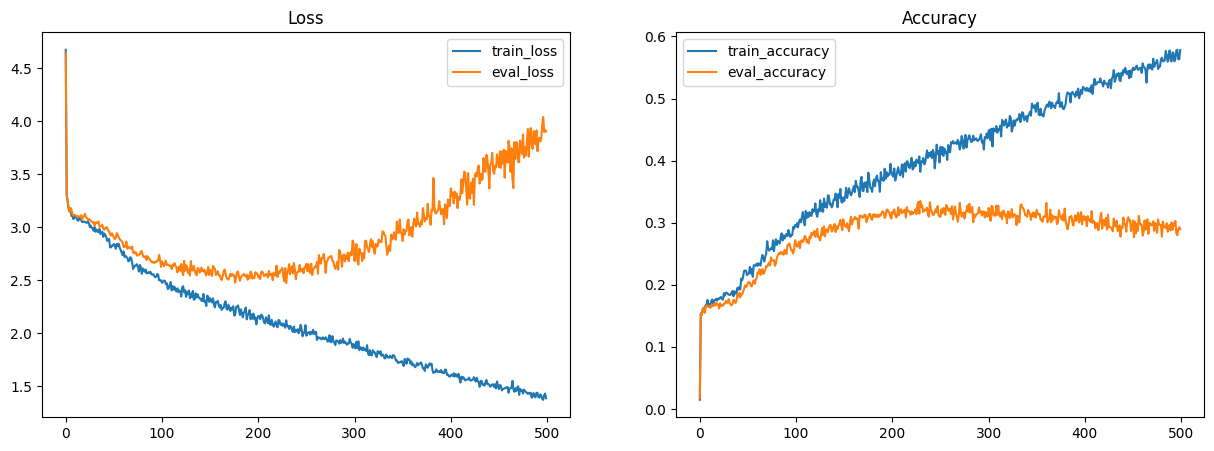

<Figure size 640x480 with 0 Axes>

In [31]:
import matplotlib.pyplot as plt  # Visualization

# Plot loss and accuracy in subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')



ax1.plot(all_train_losses, label='train_loss')
ax1.plot(all_eval_losses, label='eval_loss')

ax2.plot(all_train_accuracy, label='train_accuracy')
ax2.plot(all_test_accuracy, label='eval_accuracy')

ax1.legend()
ax2.legend()
plt.show()
plt.clf()

In [32]:
@partial(jax.jit, static_argnames=("length"))
def generate_text(rng, params, var_params, length):
    def _scan_generate(carry, _):
        random_key, context = carry
        logits = model.apply({'params': params, **var_params}, context, training=False, mutable=['other_variables'])[0]
        rng, rng_subkey = jax.random.split(random_key)
        new_token = jax.random.categorical(
          rng_subkey, logits[:, -n_tokens, :], axis=-1, shape=(1, 1)
        )
        context = jnp.concatenate([context[:, 1:], new_token], axis=1)
        return (rng, context), new_token

    _, new_tokens = jax.lax.scan(
    _scan_generate,
    (rng, jnp.zeros((1, block_size), dtype=jnp.int32)),
    (),
    length=length,
    )
    return new_tokens

In [33]:
new_tokenz = 1000
key, subkey = jax.random.split(jax.random.PRNGKey(156))
# key, subkey = jax.random.split(key)
# token_gen = generate_text(jnp.zeros((1,block_size)).astype(jnp.int32), new_tokenz, {'params': state.params})
token_gen = generate_text(key, params, var_params, new_tokenz)[:, 0, 0].tolist()
print(token_gen)
print(decode(token_gen))

[33, 33, 25, 32, 31, 0, 35, 18, 30, 16, 15, 30, 17, 10, 31, 25, 52, 63, 58, 46, 56, 1, 35, 50, 47, 60, 47, 1, 53, 43, 57, 1, 41, 57, 59, 57, 42, 52, 49, 52, 50, 30, 58, 39, 0, 1, 57, 39, 53, 43, 12, 46, 32, 46, 23, 1, 52, 43, 43, 7, 58, 56, 43, 43, 50, 1, 42, 53, 63, 52, 50, 1, 57, 50, 53, 60, 1, 6, 27, 53, 51, 1, 58, 43, 43, 52, 51, 1, 58, 53, 39, 58, 41, 1, 1, 46, 53, 56, 45, 0, 53, 46, 1, 14, 57, 61, 53, 17, 47, 40, 43, 34, 6, 0, 13, 28, 42, 47, 43, 43, 7, 1, 46, 53, 12, 1, 0, 59, 58, 53, 39, 45, 63, 1, 1, 39, 56, 45, 52, 56, 57, 43, 1, 6, 39, 39, 51, 46, 57, 54, 58, 52, 52, 43, 51, 1, 58, 53, 1, 58, 56, 43, 59, 50, 7, 59, 0, 0, 52, 47, 43, 1, 45, 44, 52, 57, 39, 46, 39, 43, 57, 58, 0, 58, 43, 1, 50, 63, 58, 1, 1, 46, 62, 47, 58, 43, 47, 53, 45, 1, 58, 43, 39, 56, 46, 6, 0, 39, 52, 42, 46, 44, 39, 43, 42, 42, 58, 1, 58, 47, 1, 50, 47, 39, 43, 1, 40, 47, 1, 1, 43, 58, 43, 57, 1, 44, 44, 59, 43, 42, 1, 61, 61, 63, 58, 58, 56, 0, 56, 13, 61, 59, 61, 40, 1, 39, 53, 51, 1, 58, 53, 47, 56

In [34]:
dsfsdhfgjdg hfdgjdgjgfjhs'####################

SyntaxError: unterminated string literal (detected at line 1) (2630675753.py, line 1)

In [ ]:
var_params['other_variables']['Mamba_0']['hidden_state'].shape

In [ ]:
params.keys()

In [ ]:
params['Dense_12']['kernel'].shape

In [ ]:
rngk = jax.random.PRNGKey(39)
xs, ys = get_batch(rngk, train_data)
print(xs[0])
print(ys[0])

In [ ]:
logits = model.apply({'params': params, **var_params}, xs[0].reshape((1,256)), training=False, mutable=['other_variables'])[0]
rng, rng_subkey = jax.random.split(rngk)
new_token = jax.random.categorical(
  rng_subkey, logits[:, -n_tokens, :], axis=-1, shape=(1, 1)
)
print(new_token)

In [ ]:
ys[0,-32:]

In [ ]:
logits.shape

In [ ]:
jax.nn.standardize(jnp.array([2.0,3.0,4.0]))

In [ ]:
@struct.dataclass
class Metrics(metrics.Collection):
    accuracy: metrics.Accuracy
    loss: metrics.Average.from_output('loss')

In [ ]:
class TrainState(train_state.TrainState):
    metrics: Metrics

def create_train_state(module, rng, learning_rate, train_shape):
    """Creates an initial `TrainState`."""
    params = module.init(rng, jnp.ones(train_shape).astype(jnp.int32), 
                         training=False)['params'] # initialize parameters by passing a template image
    tx = optax.adamw(learning_rate)
    return TrainState.create(
      apply_fn=module.apply, params=params, tx=tx,
      metrics=Metrics.empty(),
    )

In [ ]:
TrainState.create(

In [ ]:
@jax.jit
def train_step(state, inputs, targets):
    """Train for a single step."""
    def loss_fn(params):
        logits = state.apply_fn({'params': params}, inputs, training=True, 
                                rngs={"dropout": key})[0]
        loss = optax.softmax_cross_entropy_with_integer_labels(
            logits=logits, labels=targets).mean()
        return loss
    grad_fn = jax.grad(loss_fn)
    grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return state

In [ ]:
@jax.jit
def compute_metrics(*, state, inputs, targets):
    logits = state.apply_fn({'params': state.params}, inputs, training=False)[0]
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=targets).mean()
    metric_updates = state.metrics.single_from_model_output(
    logits=logits, labels=targets, loss=loss)
    metrics = state.metrics.merge(metric_updates)
    state = state.replace(metrics=metrics)
    return state

In [ ]:
num_epochs = 10
learning_rate = 0.005
init_rng = jax.random.key(0)

In [ ]:
state = create_train_state(fin_model, init_rng, learning_rate, train_shape)
del init_rng  # Must not be used anymore.

In [ ]:
metrics_history = {'train_loss': [],
                   'train_accuracy': [],
                   'test_loss': [],
                   'test_accuracy': []}

In [ ]:
SEED = 442
key = jax.random.PRNGKey(SEED)
for step in tqdm(range(max_iters)): # increase number of steps for good results...

      # sample a batch of data
    xb, yb = get_batch(key, train_data)
    state = train_step(state, xb, yb)
    state = compute_metrics(state=state, inputs=xb, targets=yb)

    key = (jax.random.split(key)[0])

    if step == 0 or (step+1) % 100 == 0: # one training epoch has passed
        for metric,value in state.metrics.compute().items(): # compute metrics
            metrics_history[f'train_{metric}'].append(value) # record metrics
        state = state.replace(metrics=state.metrics.empty()) # reset train_metrics for next training epoch

        # Compute metrics on the test set after each training epoch
        test_state = state
        x_test, y_test = get_batch(key, test_data)
    #     for test_batch in test_ds.as_numpy_iterator():
        test_state = compute_metrics(state=test_state, inputs=x_test, targets=y_test)

        for metric,value in test_state.metrics.compute().items():
            metrics_history[f'test_{metric}'].append(value)

        print(f"train epoch: {(step+1)}, "
              f"loss: {metrics_history['train_loss'][-1]}, "
              f"accuracy: {metrics_history['train_accuracy'][-1] * 100}")
        print(f"test epoch: {(step+1) }, "
          f"loss: {metrics_history['test_loss'][-1]}, "
          f"accuracy: {metrics_history['test_accuracy'][-1] * 100}")

In [ ]:
import matplotlib.pyplot as plt  # Visualization

# Plot loss and accuracy in subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')
for dataset in ('train','test'):
    ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
    ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
ax1.legend()
ax2.legend()
plt.show()
plt.clf()

In [ ]:

logits = fin_model.apply(fin_params, xb, training=False)[0]
loss = optax.softmax_cross_entropy_with_integer_labels(
            logits=logits, labels=yb).mean()

print(loss)

In [ ]:
# def generate_text(idx, max_new_tokens, params):
# # idx is (B, T) array of indices in the current context
#     for i in range(max_new_tokens):
#         # crop idx to the last block_size tokens
#         idx_cond = idx[:, -block_size:]
#         # get the predictions
#         logits = fin_model.apply(params, idx_cond)
#         # focus only on the last time step
#         logits = logits[:, -1, :] # becomes (B, C)

#         if i == 0:
#             rng, rng_subkey = jax.random.split(jax.random.PRNGKey(12))
#         else:
#             rng, rng_subkey = jax.random.split(rng)

#         idx_next = jax.random.categorical(rng_subkey, logits, axis=-1, shape=(1, 1)) # (B, 1)


#         # append sampled index to the running sequence
#         idx = jnp.concatenate([idx, idx_next], axis=-1) # (B, T+1)

#     return idx

In [ ]:
@partial(jax.jit, static_argnames=("self", "length"))
def generate_text(rng, params, length):
    def _scan_generate(carry, _):
        random_key, context = carry
        logits = fin_model.apply(params, context, training=False)[0]
        rng, rng_subkey = jax.random.split(random_key)
        new_token = jax.random.categorical(
          rng_subkey, logits[:, -1, :], axis=-1, shape=(1, 1)
        )
        context = jnp.concatenate([context[:, 1:], new_token], axis=1)
        return (rng, context), new_token

    _, new_tokens = jax.lax.scan(
    _scan_generate,
    (rng, jnp.zeros((1, block_size), dtype=jnp.int32)),
    (),
    length=length,
    )
    return new_tokens

In [ ]:
new_tokenz = 1000
key, subkey = jax.random.split(jax.random.PRNGKey(156))
# key, subkey = jax.random.split(key)
# token_gen = generate_text(jnp.zeros((1,block_size)).astype(jnp.int32), new_tokenz, {'params': state.params})
token_gen = generate_text(key, {'params': state.params}, new_tokenz)[:, 0, 0].tolist()
print(token_gen)
print(decode(token_gen))

In [ ]:
sdgh  fs

In [ ]:
state.params

In [ ]:
!pip install mamba-ssm

In [ ]:
ones = lambda *size: torch.ones(*size).float().cuda()
zeros = lambda *size: torch.zeros(*size).float().cuda()
arange = lambda n: torch.arange(n).float().cuda()
rand = lambda size: torch.rand(*size).abs().float().cuda()

def create_torch(S = 128, Ba = 2, D = 4, N = 4):
    x = rand((Ba, 1, D, S))
    a = -ones((Ba, N, D, 1))
    b = ones((Ba, N, 1, S)) * 0.1
    c = rand((Ba, N, 1, S)) * 0.1
    delta = rand((Ba, 1, D, S)) * 0.1
    return x, a, b, c, delta

In [ ]:
import selective_scan_cuda

xx, aa, bb, cc, ddelta = create_torch()
y_from_repo = selective_scan_cuda.fwd(xx.squeeze(1), ddelta.squeeze(1), aa[0].squeeze(-1).T, bb.squeeze(-2)[:, None, :, :], cc.squeeze(-2)[:, None, :, :], None, None, None, False)
y_from_repo

In [ ]:
def discretize(a, b, delta):
    da = delta * a
    a_ = jnp.exp(da)
    b_ = b * delta
    return a_, b_

def ssm(x, a, b, c, delta):
    "Jax Implementation"
    y = []
    h = 0
    a_, b_ = discretize(a, b, delta)
    for k in range(x.shape[-1]):
        h = a_[..., k] * h + b_[..., k] * x[..., k]
        y.append((c[..., k] * h).sum(1, keepdims=True))
    return h, jnp.stack(y, -1)


In [ ]:
_, y_ = ssm(xx.cpu().numpy(), aa.cpu().numpy(), bb.cpu().numpy(), cc.cpu().numpy(), ddelta.cpu().numpy())

In [ ]:
from mamba_ssm import Mamba as Mamba_T
torch_mamba = Mamba_T(
      # This module uses roughly 3 * expand * d_model^2 parameters
      d_model=n_embd, # Model dimension d_model
      d_state=16,  # SSM state expansion factor
      d_conv=4,    # Local convolution width
      expand=2,    # Block expansion factor
)

In [ ]:
xm = x = rand((1, 1, n_embd, 32))
xm.shape

In [ ]:
torch_mamba(xm.squeeze(1))

In [ ]:
torch_mamba.in_proj

In [ ]:
y_mamba_repo = mamba_inner_fn()

In [ ]:
xm.squeeze(1).shape